# imports

In [15]:
import sys
sys.path.append('./lib')

import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/' # Working directory 

import numpy as np
import torch
import pickle
import os
import optuna
from time import time
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import NDNLayer, ConvLayer, STconvLayer, Tlayer, ChannelLayer, IterSTlayer, ReadoutLayer
from NDNT.networks import FFnetwork
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

Running on Computer: [ca1]
Save_dir = /home/dbutts/ColorV1/CLRworkspace/
cuda:1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [2]:
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
104.39021968841553 sec elapsed
167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations


In [3]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][:, 0]

data.set_cells(valET)

174 out of 195 units used
Output set to 174 cells


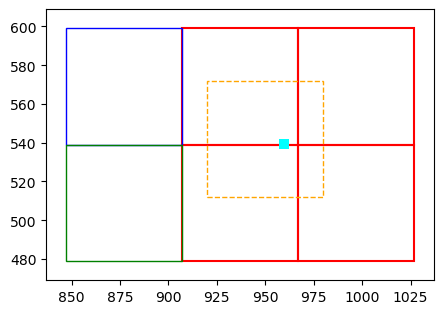

  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [4]:
# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# Make 60x60 STAs (and GLMs)
Xshift = 14 #8+4 
Yshift = -3 #-10+4
NX = 60

new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)

In [5]:
goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))
dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')

68.5% fixations remaining


In [13]:
data.dfs.shape

torch.Size([167520, 239])

 # STAs

In [23]:
data.num_lags, data.stim.shape, data.robs.shape

(10, torch.Size([167520, 3600]), torch.Size([167520, 239]))

In [102]:
print(valET)

[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  66  67  68  69  70  71  72  73  75
  77  78  79  80  81  82  83  84  86  87  88  89  90  92  93  95  96  97
  98  99 100 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 152 153 154 155 156 157 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 182 183 184 185 187 188 189 190 191 192 193 194 195 196 197
 198 200 203 204 205 206 207 208 209 210 211 213 214 216 217 218 219 220
 221 222 224 226 227 228 230 231 232 233 235 236]


In [31]:
Reff = torch.mul(data.robs[:, valET], data.dfs[:, valET])
nspks = torch.sum(Reff, axis=0)
lag = 4
stas = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).numpy()
stas.shape

(60, 60, 174)

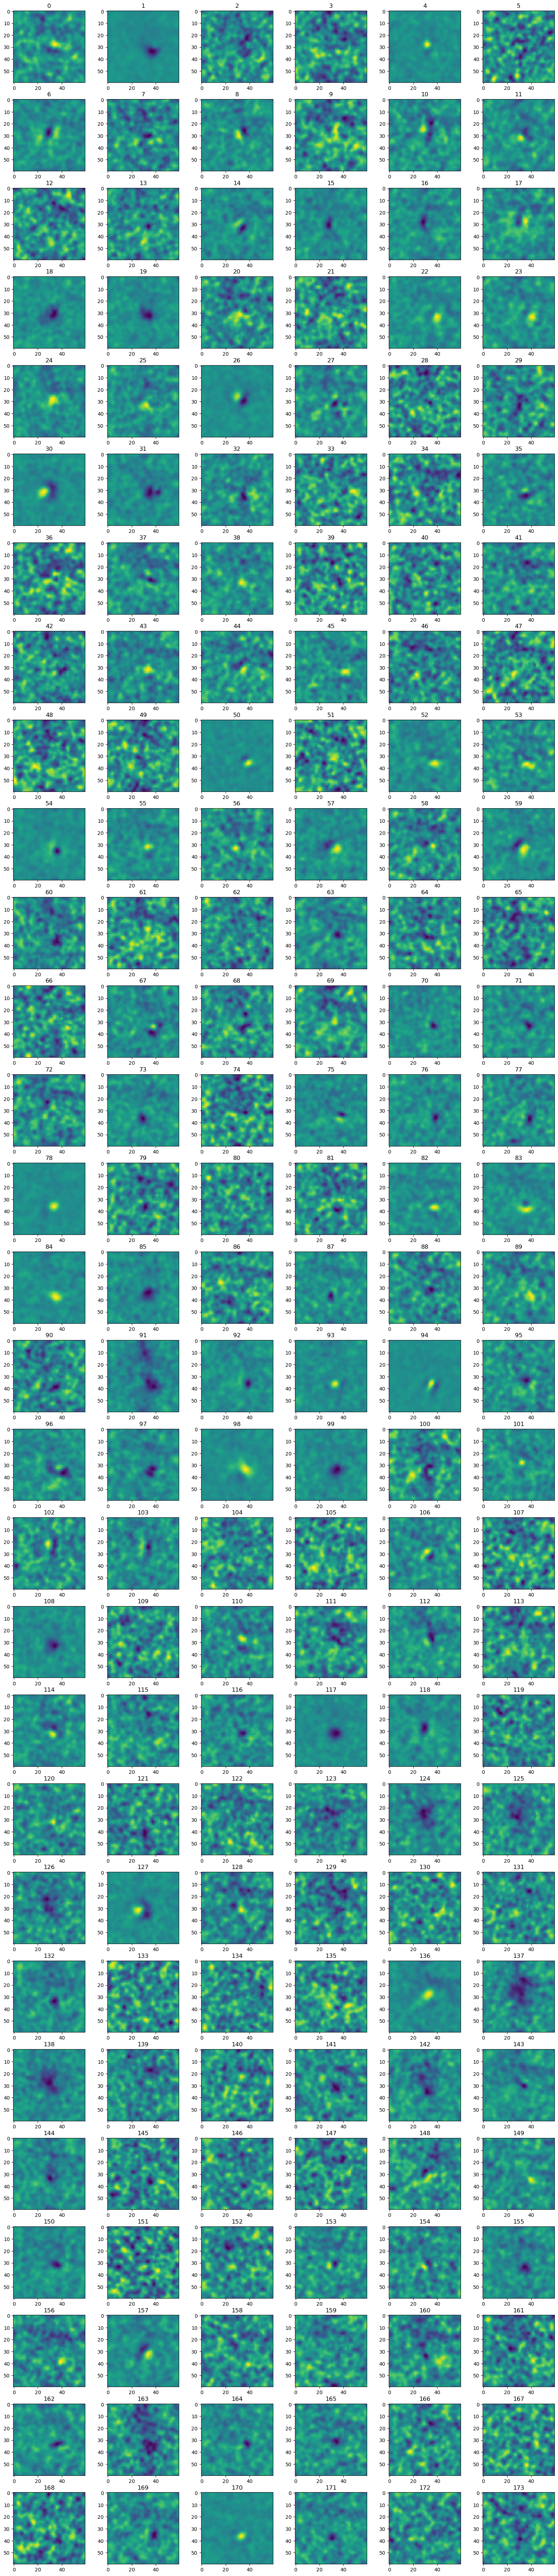

In [111]:
# plot some STAs
ss(29,6)
for cc in range(NCv):
    plt.subplot(29,6, cc+1)
    imagesc(stas[:,:, cc])
    plt.title(str(cc))
plt.show()

# interesting cells

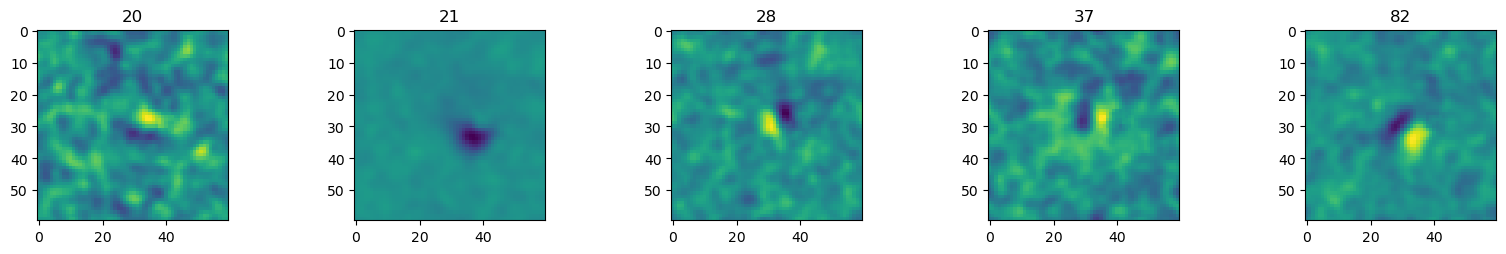

In [113]:
ss(1,5)
interesting_cells = [0, 1, 8, 17, 59]
for i, cc in enumerate(interesting_cells):
    plt.subplot(1,5, i+1)
    imagesc(stas[:,:, cc])
    plt.title(str(valET[cc]))
plt.show()

In [85]:
#set up fits
Treg = 1
Xreg = 20 # [20]
L1reg = 0.1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# gqm net
num_subs = 2
gqm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, num_inh=0, bias=False, num_lags=num_lags,
    NLtype='square', initialize_center = True)
gqm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_qnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [gqm_layer] )

#combine glm
comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#combine gqm
comb2_layer = ChannelLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net2_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='normal')
net2_comb['layer_list'][0]['bias'] = True

# Drifts

## fit Drifts

In [114]:
import optuna

drifts = []

for cc in interesting_cells:
    drift_model_filename = 'models/glms_02/drift_model_cc'+str(valET[cc])+'.pkl'
    drift_study_filename = 'models/glms_02/drift_study_cc'+str(valET[cc])+'.pkl'

    # continue if the file already exists
    if os.path.isfile(drift_model_filename):
        # load the model and continue
        print('loading model', cc)
        with open(drift_model_filename, 'rb') as f:
            drifts.append(pickle.load(f))
        continue

    data.set_cells(valET[cc])

    drifts_temp = []

    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=1e-8,
            tolerance_grad=1e-8,
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)

        # drift network
        drift_pars1 = NDNLayer.layer_dict(
            input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
        drift_pars1['reg_vals'] = {'d2t': trial.suggest_float('d2t', 0.0, 1.0), 'bcs':{'d2t':0} }
        # for stand-alone drift model
        drift_pars1N = deepcopy(drift_pars1)
        drift_pars1N['NLtype'] = 'softplus'
        drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

        drift_ndn = NDN.NDN(
            layer_list = [drift_pars1N], loss_type='poisson')
        drift_ndn.block_sample=True
        drift_ndn.networks[0].xstim_n = 'Xdrift'

        drift_ndn.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
        LL = drift_ndn.eval_models(data[data.val_blks], null_adjusted=False)[0]

        drift_model = Model(drift_ndn, LL, trial)
        drifts_temp.append(drift_model)

        return LL

    study = optuna.create_study(direction='minimize')

    # enqueue initial parameters
    study.enqueue_trial(
        {'d2t': Dreg})

    study.optimize(objective, n_trials=10)
    
    best_model = drifts_temp[study.best_trial.number]

    drifts.append(best_model)

    with open(drift_model_filename, 'wb') as f:
        pickle.dump(best_model, f)

    with open(drift_study_filename, 'wb') as f:
        pickle.dump(study, f)

    print(study.best_trial.number, study.best_params)

[I 2023-07-10 15:48:49,842] A new study created in memory with name: no-name-886608cc-6ca5-4ec3-ba37-acefb098c303


Output set to 1 cells


[I 2023-07-10 15:48:50,504] Trial 0 finished with value: 2.7353742122650146 and parameters: {'d2t': 0.1}. Best is trial 0 with value: 2.7353742122650146.
[I 2023-07-10 15:48:51,085] Trial 1 finished with value: 2.7356584072113037 and parameters: {'d2t': 0.9424469114008592}. Best is trial 0 with value: 2.7353742122650146.
[I 2023-07-10 15:48:51,637] Trial 2 finished with value: 2.7356433868408203 and parameters: {'d2t': 0.778731661693163}. Best is trial 0 with value: 2.7353742122650146.
[I 2023-07-10 15:48:52,097] Trial 3 finished with value: 2.7355072498321533 and parameters: {'d2t': 0.2466375005266549}. Best is trial 0 with value: 2.7353742122650146.
[I 2023-07-10 15:48:52,623] Trial 4 finished with value: 2.7356183528900146 and parameters: {'d2t': 0.5997205787962651}. Best is trial 0 with value: 2.7353742122650146.
[I 2023-07-10 15:48:53,177] Trial 5 finished with value: 2.7356081008911133 and parameters: {'d2t': 0.6740864347648245}. Best is trial 0 with value: 2.7353742122650146.
[I

0 {'d2t': 0.1}
Output set to 1 cells


[I 2023-07-10 15:48:55,610] Trial 0 finished with value: 1.2411673069000244 and parameters: {'d2t': 0.1}. Best is trial 0 with value: 1.2411673069000244.
[I 2023-07-10 15:48:56,059] Trial 1 finished with value: 1.2411373853683472 and parameters: {'d2t': 0.3176339938965169}. Best is trial 1 with value: 1.2411373853683472.
[I 2023-07-10 15:48:56,504] Trial 2 finished with value: 1.2411162853240967 and parameters: {'d2t': 0.5229512741828878}. Best is trial 2 with value: 1.2411162853240967.
[I 2023-07-10 15:48:57,005] Trial 3 finished with value: 1.2410945892333984 and parameters: {'d2t': 0.9678459361641647}. Best is trial 3 with value: 1.2410945892333984.
[I 2023-07-10 15:48:57,405] Trial 4 finished with value: 1.2411751747131348 and parameters: {'d2t': 0.05072607992600753}. Best is trial 3 with value: 1.2410945892333984.
[I 2023-07-10 15:48:57,872] Trial 5 finished with value: 1.2411036491394043 and parameters: {'d2t': 0.729195030680605}. Best is trial 3 with value: 1.2410945892333984.
[

3 {'d2t': 0.9678459361641647}
Output set to 1 cells


[I 2023-07-10 15:49:00,239] Trial 0 finished with value: 3.2687957286834717 and parameters: {'d2t': 0.1}. Best is trial 0 with value: 3.2687957286834717.
[I 2023-07-10 15:49:00,983] Trial 1 finished with value: 3.2693967819213867 and parameters: {'d2t': 0.8287002576560094}. Best is trial 0 with value: 3.2687957286834717.
[I 2023-07-10 15:49:01,606] Trial 2 finished with value: 3.2690927982330322 and parameters: {'d2t': 0.3039698899470584}. Best is trial 0 with value: 3.2687957286834717.
[I 2023-07-10 15:49:02,082] Trial 3 finished with value: 3.2685227394104004 and parameters: {'d2t': 0.03215303565936234}. Best is trial 3 with value: 3.2685227394104004.
[I 2023-07-10 15:49:02,845] Trial 4 finished with value: 3.2693862915039062 and parameters: {'d2t': 0.7682572744691585}. Best is trial 3 with value: 3.2685227394104004.
[I 2023-07-10 15:49:03,421] Trial 5 finished with value: 3.268960475921631 and parameters: {'d2t': 0.1860713852702801}. Best is trial 3 with value: 3.2685227394104004.
[

3 {'d2t': 0.03215303565936234}
Output set to 1 cells


[I 2023-07-10 15:49:06,717] Trial 0 finished with value: 2.967313528060913 and parameters: {'d2t': 0.1}. Best is trial 0 with value: 2.967313528060913.
[I 2023-07-10 15:49:07,187] Trial 1 finished with value: 2.9673666954040527 and parameters: {'d2t': 0.18523449983707896}. Best is trial 0 with value: 2.967313528060913.
[I 2023-07-10 15:49:07,677] Trial 2 finished with value: 2.9674065113067627 and parameters: {'d2t': 0.30973424560385676}. Best is trial 0 with value: 2.967313528060913.
[I 2023-07-10 15:49:08,247] Trial 3 finished with value: 2.967419147491455 and parameters: {'d2t': 0.6274498898473685}. Best is trial 0 with value: 2.967313528060913.
[I 2023-07-10 15:49:08,813] Trial 4 finished with value: 2.967416524887085 and parameters: {'d2t': 0.5595819978483733}. Best is trial 0 with value: 2.967313528060913.
[I 2023-07-10 15:49:09,411] Trial 5 finished with value: 2.9674272537231445 and parameters: {'d2t': 0.9066223941927198}. Best is trial 0 with value: 2.967313528060913.
[I 2023-

6 {'d2t': 0.071587360831188}
Output set to 1 cells


[I 2023-07-10 15:49:11,887] Trial 0 finished with value: 2.847010374069214 and parameters: {'d2t': 0.1}. Best is trial 0 with value: 2.847010374069214.
[I 2023-07-10 15:49:12,394] Trial 1 finished with value: 2.8467159271240234 and parameters: {'d2t': 0.5280358991320606}. Best is trial 1 with value: 2.8467159271240234.
[I 2023-07-10 15:49:12,858] Trial 2 finished with value: 2.846856117248535 and parameters: {'d2t': 0.20637091861000212}. Best is trial 1 with value: 2.8467159271240234.
[I 2023-07-10 15:49:13,339] Trial 3 finished with value: 2.846865177154541 and parameters: {'d2t': 0.2077329415005057}. Best is trial 1 with value: 2.8467159271240234.
[I 2023-07-10 15:49:13,893] Trial 4 finished with value: 2.8466873168945312 and parameters: {'d2t': 0.5975689408421947}. Best is trial 4 with value: 2.8466873168945312.
[I 2023-07-10 15:49:14,318] Trial 5 finished with value: 2.8470282554626465 and parameters: {'d2t': 0.08855261145669635}. Best is trial 4 with value: 2.8466873168945312.
[I 

9 {'d2t': 0.8856476410256253}


## plot Drifts

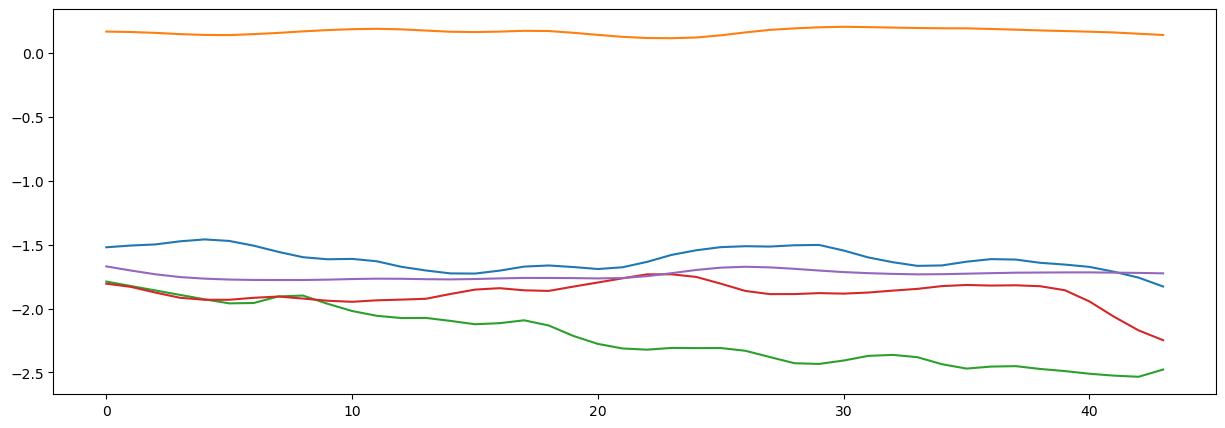

In [115]:
fig = plt.figure(figsize=(15,5))
for drift in drifts:
    plt.plot(drift.ndn_model.networks[0].layers[0].get_weights())

# GLMs

## fit GLMs

In [116]:
glms = []
for i, cc in enumerate(interesting_cells):
    glm_model_filename = 'models/glms_02/glm_model_cc'+str(valET[cc])+'.pkl'
    glm_study_filename = 'models/glms_02/glm_study_cc'+str(valET[cc])+'.pkl'

    drift_weights = drifts[i].ndn_model.networks[0].layers[0].weight.data[:,0]

    # continue if the file already exists
    if os.path.isfile(glm_model_filename):
        # load the model and continue
        print('loading model', cc)
        with open(glm_model_filename, 'rb') as f:
            glms.append(pickle.load(f))
        continue

    data.set_cells(valET[cc])

    LLsNULL = drifts[i].LLs

    glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    glm.block_sample=True
    glm.networks[1].layers[0].weight.data[:,0] = deepcopy(drift_weights)
    glm.networks[1].layers[0].set_parameters(val=False)
    glm.networks[2].layers[0].set_parameters(val=False,name='weight')

    glms_temp = []

    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=trial.suggest_float('tolerance_change', 1e-10, 1e-6),
            tolerance_grad=trial.suggest_float('tolerance_grad', 1e-10, 1e-6),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter=500,
            device=device)

        glm.networks[0].layers[0].reg.vals['d2x'] = trial.suggest_float('d2x', 10, 30)
        glm.networks[0].layers[0].reg.vals['d2t'] = trial.suggest_float('d2t', 0.5, 2)
        glm.networks[0].layers[0].reg.vals['d2xt'] = trial.suggest_float('d2xt', 0.001, 10000)
        glm.networks[0].layers[0].reg.vals['l1'] = trial.suggest_float('l1', 0.01, 1)
        glm.networks[0].layers[0].reg.vals['glocalx'] = trial.suggest_float('glocalx', 0.001, 20)

        glm.fit(data, force_dict_training=True, trial=trial, **lbfgs_pars)
        LL = glm.eval_models(data[data.val_blks], null_adjusted=False)[0]

        null_adjusted_LL = LLsNULL - LL

        glm_model = Model(glm, null_adjusted_LL, trial)
        glms_temp.append(glm_model)

        return null_adjusted_LL

    study = optuna.create_study(direction='maximize')

    # enqueue initial parameters
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 0.001,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 0.01,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 0.1,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 1,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 10,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})

    study.optimize(objective, n_trials=15)

    best_model = glms_temp[study.best_trial.number]

    glms.append(best_model)

    # save the model
    with open(glm_model_filename, 'wb') as f:
        pickle.dump(best_model, f)
        
    # save the study
    with open(glm_study_filename, 'wb') as f:
        pickle.dump(study, f)

    print(study.best_trial.number, study.best_params)

[I 2023-07-10 15:49:43,906] A new study created in memory with name: no-name-55ba04ee-7505-44bc-80ec-3822d378ceab


Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.462716579437256 sec elapsed


[I 2023-07-10 15:49:47,027] Trial 0 finished with value: -0.0022242069244384766 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.0022242069244384766.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0649588108062744 sec elapsed


[I 2023-07-10 15:49:48,735] Trial 1 finished with value: -0.0022242069244384766 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.0022242069244384766.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0584640502929688 sec elapsed


[I 2023-07-10 15:49:50,432] Trial 2 finished with value: -0.0022242069244384766 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.0022242069244384766.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0807359218597412 sec elapsed


[I 2023-07-10 15:49:52,169] Trial 3 finished with value: -0.0022242069244384766 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.0022242069244384766.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.4953587055206299 sec elapsed


[I 2023-07-10 15:49:54,308] Trial 4 finished with value: -0.0021762847900390625 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: -0.0021762847900390625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.3266985416412354 sec elapsed


[I 2023-07-10 15:49:57,292] Trial 5 finished with value: 0.0017426013946533203 and parameters: {'tolerance_change': 7.294999935461313e-07, 'tolerance_grad': 5.787665691194556e-08, 'd2x': 24.579559673449275, 'd2t': 1.2193141266904148, 'd2xt': 7662.780795811632, 'l1': 0.46575454460602744, 'glocalx': 17.233794236045785}. Best is trial 5 with value: 0.0017426013946533203.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.272327184677124 sec elapsed


[I 2023-07-10 15:49:59,223] Trial 6 finished with value: 0.0017094612121582031 and parameters: {'tolerance_change': 6.66358568616054e-07, 'tolerance_grad': 2.0391812897052215e-07, 'd2x': 24.531728117888587, 'd2t': 1.704132843356705, 'd2xt': 7853.481384480286, 'l1': 0.2325769732168119, 'glocalx': 17.082545143739353}. Best is trial 5 with value: 0.0017426013946533203.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0195517539978027 sec elapsed


[I 2023-07-10 15:50:01,882] Trial 7 finished with value: -0.0023734569549560547 and parameters: {'tolerance_change': 8.68321256344344e-07, 'tolerance_grad': 4.775695422715799e-07, 'd2x': 13.638300587762162, 'd2t': 1.28064884595772, 'd2xt': 211.8051889611164, 'l1': 0.9857134861484512, 'glocalx': 6.118224367339741}. Best is trial 5 with value: 0.0017426013946533203.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9138522148132324 sec elapsed


[I 2023-07-10 15:50:04,455] Trial 8 finished with value: 0.0008656978607177734 and parameters: {'tolerance_change': 5.78686656435333e-07, 'tolerance_grad': 6.68070506792923e-07, 'd2x': 28.825832928554437, 'd2t': 0.6499490907030303, 'd2xt': 1631.9438077949646, 'l1': 0.9396410589251492, 'glocalx': 11.812434405990945}. Best is trial 5 with value: 0.0017426013946533203.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.212709903717041 sec elapsed


[I 2023-07-10 15:50:07,312] Trial 9 finished with value: -0.00016760826110839844 and parameters: {'tolerance_change': 4.364446486445492e-07, 'tolerance_grad': 1.6742031676422733e-07, 'd2x': 19.04540682874515, 'd2t': 1.0733697271624436, 'd2xt': 5914.021189478118, 'l1': 0.48253644941283536, 'glocalx': 1.3147820225702012}. Best is trial 5 with value: 0.0017426013946533203.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0230820178985596 sec elapsed


[I 2023-07-10 15:50:10,014] Trial 10 finished with value: 0.0019235610961914062 and parameters: {'tolerance_change': 9.886562807754576e-07, 'tolerance_grad': 8.389826277902575e-07, 'd2x': 28.608587998830437, 'd2t': 1.905384437276893, 'd2xt': 9932.982644795691, 'l1': 0.5875217125806881, 'glocalx': 19.273771868786284}. Best is trial 10 with value: 0.0019235610961914062.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2886736392974854 sec elapsed


[I 2023-07-10 15:50:11,965] Trial 11 finished with value: 0.0019097328186035156 and parameters: {'tolerance_change': 9.538788420587422e-07, 'tolerance_grad': 9.413228245005607e-07, 'd2x': 29.925450173345133, 'd2t': 1.9843240727434845, 'd2xt': 9894.310705775604, 'l1': 0.5262131967362779, 'glocalx': 19.976060301001308}. Best is trial 10 with value: 0.0019235610961914062.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2854268550872803 sec elapsed


[I 2023-07-10 15:50:13,913] Trial 12 finished with value: 0.0019145011901855469 and parameters: {'tolerance_change': 9.86496448575847e-07, 'tolerance_grad': 9.894960218668079e-07, 'd2x': 29.18326012546213, 'd2t': 1.9957686579155935, 'd2xt': 9948.17260561479, 'l1': 0.6815966108939803, 'glocalx': 19.44906001066728}. Best is trial 10 with value: 0.0019235610961914062.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.286707878112793 sec elapsed


[I 2023-07-10 15:50:15,868] Trial 13 finished with value: 0.0019159317016601562 and parameters: {'tolerance_change': 9.775511189943488e-07, 'tolerance_grad': 9.758513647055437e-07, 'd2x': 26.37007275502541, 'd2t': 1.9752532136395786, 'd2xt': 9797.202731276666, 'l1': 0.697338522224515, 'glocalx': 19.49040536510768}. Best is trial 10 with value: 0.0019235610961914062.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.4137639999389648 sec elapsed


[I 2023-07-10 15:50:17,952] Trial 14 finished with value: 0.0018644332885742188 and parameters: {'tolerance_change': 8.425432116209313e-07, 'tolerance_grad': 8.54299244053233e-07, 'd2x': 26.166330638641234, 'd2t': 1.7186286560643338, 'd2xt': 8878.064935393102, 'l1': 0.7501824142588077, 'glocalx': 16.065410873787076}. Best is trial 10 with value: 0.0019235610961914062.
[I 2023-07-10 15:50:17,960] A new study created in memory with name: no-name-8efd4306-b605-455b-a3a2-8e12be6d071a


10 {'tolerance_change': 9.886562807754576e-07, 'tolerance_grad': 8.389826277902575e-07, 'd2x': 28.608587998830437, 'd2t': 1.905384437276893, 'd2xt': 9932.982644795691, 'l1': 0.5875217125806881, 'glocalx': 19.273771868786284}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.521409273147583 sec elapsed


[I 2023-07-10 15:50:22,139] Trial 0 finished with value: 0.0537947416305542 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.0537947416305542.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.830531120300293 sec elapsed


[I 2023-07-10 15:50:24,636] Trial 1 finished with value: 0.05379533767700195 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.05379533767700195.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2115802764892578 sec elapsed


[I 2023-07-10 15:50:26,507] Trial 2 finished with value: 0.05379605293273926 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.3023080825805664 sec elapsed


[I 2023-07-10 15:50:28,451] Trial 3 finished with value: 0.05379486083984375 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.6862659454345703 sec elapsed


[I 2023-07-10 15:50:30,777] Trial 4 finished with value: 0.05376863479614258 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4596328735351562 sec elapsed


[I 2023-07-10 15:50:33,905] Trial 5 finished with value: 0.04207026958465576 and parameters: {'tolerance_change': 2.538473102937223e-07, 'tolerance_grad': 5.631239168685992e-07, 'd2x': 22.44160974682132, 'd2t': 0.914134465119627, 'd2xt': 3484.3406745977854, 'l1': 0.48015546478098875, 'glocalx': 17.400266023296403}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.710505485534668 sec elapsed


[I 2023-07-10 15:50:36,272] Trial 6 finished with value: 0.043468594551086426 and parameters: {'tolerance_change': 3.059906727756108e-07, 'tolerance_grad': 8.448913144569257e-07, 'd2x': 24.562194474902864, 'd2t': 1.1175453721533062, 'd2xt': 2896.9069876743624, 'l1': 0.9599558670548028, 'glocalx': 16.80591268996118}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.706207275390625 sec elapsed


[I 2023-07-10 15:50:38,620] Trial 7 finished with value: 0.04185175895690918 and parameters: {'tolerance_change': 3.046516917651612e-07, 'tolerance_grad': 6.195779391809254e-07, 'd2x': 26.098206504030124, 'd2t': 0.5115808196522595, 'd2xt': 3582.801537570468, 'l1': 0.05333360588914975, 'glocalx': 17.32139447691634}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.226940155029297 sec elapsed


[I 2023-07-10 15:50:41,489] Trial 8 finished with value: 0.033564209938049316 and parameters: {'tolerance_change': 4.122004517041292e-07, 'tolerance_grad': 2.9412802976316122e-08, 'd2x': 21.699298912255728, 'd2t': 1.7475544898329514, 'd2xt': 9727.97450250502, 'l1': 0.8003199047870805, 'glocalx': 5.459678917552432}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.11539363861084 sec elapsed


[I 2023-07-10 15:50:44,248] Trial 9 finished with value: 0.04453098773956299 and parameters: {'tolerance_change': 7.229464385272876e-07, 'tolerance_grad': 7.041049368281351e-07, 'd2x': 14.664504663891393, 'd2t': 1.3453681482160944, 'd2xt': 2432.0480080839875, 'l1': 0.660104840330434, 'glocalx': 18.506732384423913}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.115741729736328 sec elapsed


[I 2023-07-10 15:50:47,026] Trial 10 finished with value: 0.037242889404296875 and parameters: {'tolerance_change': 9.289493257485031e-07, 'tolerance_grad': 3.067792933958509e-07, 'd2x': 29.327668186871563, 'd2t': 1.4480960811255965, 'd2xt': 6373.731942197456, 'l1': 0.339820751617232, 'glocalx': 0.013982829887670079}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.3456027507781982 sec elapsed


[I 2023-07-10 15:50:50,033] Trial 11 finished with value: 0.04762411117553711 and parameters: {'tolerance_change': 1.853475648109861e-07, 'tolerance_grad': 2.564261217613927e-07, 'd2x': 15.833278322324528, 'd2t': 0.726600282487542, 'd2xt': 1501.9812381774823, 'l1': 0.271859973215806, 'glocalx': 13.914680760744037}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.5028076171875 sec elapsed


[I 2023-07-10 15:50:52,214] Trial 12 finished with value: 0.046984076499938965 and parameters: {'tolerance_change': 5.829812566203589e-07, 'tolerance_grad': 2.189373551890613e-07, 'd2x': 10.54252303723909, 'd2t': 1.1924537664424828, 'd2xt': 1716.8124359076387, 'l1': 0.22736185283076854, 'glocalx': 12.995682998578173}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.1268961429595947 sec elapsed


[I 2023-07-10 15:50:55,020] Trial 13 finished with value: 0.039772629737854004 and parameters: {'tolerance_change': 1.0418351682456158e-07, 'tolerance_grad': 4.200576848967414e-07, 'd2x': 17.208304539820652, 'd2t': 0.7648225215287209, 'd2xt': 4865.330665717578, 'l1': 0.40056450343259786, 'glocalx': 6.759147455136544}. Best is trial 2 with value: 0.05379605293273926.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.3419761657714844 sec elapsed


[I 2023-07-10 15:50:58,041] Trial 14 finished with value: 0.05059671401977539 and parameters: {'tolerance_change': 1.9476648768876516e-07, 'tolerance_grad': 1.5774013322346263e-07, 'd2x': 17.698460267713465, 'd2t': 1.385582367346579, 'd2xt': 725.2820908767496, 'l1': 0.010786845741106277, 'glocalx': 13.169961989111957}. Best is trial 2 with value: 0.05379605293273926.
[I 2023-07-10 15:50:58,053] A new study created in memory with name: no-name-7897a268-0a34-463a-87d2-b2f0bbb9331a


2 {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.54327654838562 sec elapsed


[I 2023-07-10 15:51:01,242] Trial 0 finished with value: 0.020382404327392578 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.020382404327392578.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.20477294921875 sec elapsed


[I 2023-07-10 15:51:03,119] Trial 1 finished with value: 0.02038288116455078 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.02038288116455078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0855236053466797 sec elapsed


[I 2023-07-10 15:51:04,849] Trial 2 finished with value: 0.02038288116455078 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.02038288116455078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0666553974151611 sec elapsed


[I 2023-07-10 15:51:06,558] Trial 3 finished with value: 0.02038288116455078 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.02038288116455078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.7082185745239258 sec elapsed


[I 2023-07-10 15:51:08,924] Trial 4 finished with value: 0.0203859806060791 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.024555206298828 sec elapsed


[I 2023-07-10 15:51:11,607] Trial 5 finished with value: 0.014510393142700195 and parameters: {'tolerance_change': 9.472718901335156e-07, 'tolerance_grad': 6.144574972122155e-07, 'd2x': 25.426548223145574, 'd2t': 0.77324146938687, 'd2xt': 3923.2224166959318, 'l1': 0.2601003721395725, 'glocalx': 19.28265008586988}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9211640357971191 sec elapsed


[I 2023-07-10 15:51:14,186] Trial 6 finished with value: 0.019440889358520508 and parameters: {'tolerance_change': 8.076941138766099e-07, 'tolerance_grad': 5.162989355335793e-07, 'd2x': 12.60466387303088, 'd2t': 0.9981080610974125, 'd2xt': 435.815480184839, 'l1': 0.7150873750364855, 'glocalx': 13.53693907934613}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.7100625038146973 sec elapsed


[I 2023-07-10 15:51:16,535] Trial 7 finished with value: 0.017357826232910156 and parameters: {'tolerance_change': 5.551817503156912e-07, 'tolerance_grad': 9.121927371559006e-07, 'd2x': 16.739069528838787, 'd2t': 1.8146229205924183, 'd2xt': 1408.6010591949357, 'l1': 0.26098847741743303, 'glocalx': 7.977276696842784}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.5830504894256592 sec elapsed


[I 2023-07-10 15:51:18,760] Trial 8 finished with value: 0.015787124633789062 and parameters: {'tolerance_change': 3.4822070202470815e-07, 'tolerance_grad': 7.576755812047315e-07, 'd2x': 23.100596589594517, 'd2t': 1.7291534269514037, 'd2xt': 2263.271279512425, 'l1': 0.1010197372328654, 'glocalx': 4.798752746206506}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.203108787536621 sec elapsed


[I 2023-07-10 15:51:21,608] Trial 9 finished with value: 0.013302087783813477 and parameters: {'tolerance_change': 6.396832967511347e-07, 'tolerance_grad': 1.91609609605062e-07, 'd2x': 18.46383232847659, 'd2t': 1.1715651810491297, 'd2xt': 6082.183354205454, 'l1': 0.8094344149738927, 'glocalx': 4.783508165973939}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.338768243789673 sec elapsed


[I 2023-07-10 15:51:24,619] Trial 10 finished with value: 0.01161336898803711 and parameters: {'tolerance_change': 2.878152109071687e-07, 'tolerance_grad': 3.5272056465834707e-07, 'd2x': 29.61153814127099, 'd2t': 0.5911437694267573, 'd2xt': 9011.857767463966, 'l1': 0.514109005997116, 'glocalx': 1.1298794841866222}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.107656955718994 sec elapsed


[I 2023-07-10 15:51:27,388] Trial 11 finished with value: 0.015837430953979492 and parameters: {'tolerance_change': 2.2457034026997375e-07, 'tolerance_grad': 2.636828320653502e-07, 'd2x': 14.975176501083627, 'd2t': 1.4663151295723258, 'd2xt': 2485.5324935861045, 'l1': 0.3400780855882716, 'glocalx': 13.813210824051996}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.891646385192871 sec elapsed


[I 2023-07-10 15:51:29,958] Trial 12 finished with value: 0.015335559844970703 and parameters: {'tolerance_change': 1.662234661255243e-07, 'tolerance_grad': 1.760164067468684e-07, 'd2x': 10.062764874597566, 'd2t': 1.3149682526899096, 'd2xt': 3212.0685045994946, 'l1': 0.9883032690095311, 'glocalx': 13.85020859171652}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9208223819732666 sec elapsed


[I 2023-07-10 15:51:32,540] Trial 13 finished with value: 0.01705312728881836 and parameters: {'tolerance_change': 4.0359465661935624e-07, 'tolerance_grad': 3.72608219909612e-07, 'd2x': 22.733694804429597, 'd2t': 0.5057939142057231, 'd2xt': 1583.3662341553056, 'l1': 0.4086866567636363, 'glocalx': 6.980723094111352}. Best is trial 4 with value: 0.0203859806060791.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9982707500457764 sec elapsed


[I 2023-07-10 15:51:35,217] Trial 14 finished with value: 0.014033079147338867 and parameters: {'tolerance_change': 1.545437019109225e-07, 'tolerance_grad': 1.4172473934765256e-07, 'd2x': 16.491858084573792, 'd2t': 0.7847689992293927, 'd2xt': 4460.623519158724, 'l1': 0.0332315741086871, 'glocalx': 11.641095966139236}. Best is trial 4 with value: 0.0203859806060791.
[I 2023-07-10 15:51:35,227] A new study created in memory with name: no-name-44ea4799-55e2-4338-a8d8-091d04db2e2e


4 {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.9683659076690674 sec elapsed


[I 2023-07-10 15:51:38,856] Trial 0 finished with value: 0.06315350532531738 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.06315350532531738.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.224055290222168 sec elapsed


[I 2023-07-10 15:51:40,739] Trial 1 finished with value: 0.06315445899963379 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.06315445899963379.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.1816396713256836 sec elapsed


[I 2023-07-10 15:51:42,579] Trial 2 finished with value: 0.06315469741821289 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2036607265472412 sec elapsed


[I 2023-07-10 15:51:44,440] Trial 3 finished with value: 0.06315445899963379 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.8064625263214111 sec elapsed


[I 2023-07-10 15:51:46,888] Trial 4 finished with value: 0.06314349174499512 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6341092586517334 sec elapsed


[I 2023-07-10 15:51:50,164] Trial 5 finished with value: 0.04413104057312012 and parameters: {'tolerance_change': 2.1940770420312582e-07, 'tolerance_grad': 5.974164347350286e-07, 'd2x': 25.889300581978656, 'd2t': 1.8280060581489566, 'd2xt': 6212.006891831712, 'l1': 0.6156677790131898, 'glocalx': 10.952856659990031}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.5885181427001953 sec elapsed


[I 2023-07-10 15:51:52,394] Trial 6 finished with value: 0.04633378982543945 and parameters: {'tolerance_change': 6.146168565137103e-07, 'tolerance_grad': 1.0543594171109107e-07, 'd2x': 22.480737637759155, 'd2t': 1.471741651773959, 'd2xt': 4813.666829060988, 'l1': 0.5701713097246206, 'glocalx': 12.364895326377937}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.108597755432129 sec elapsed


[I 2023-07-10 15:51:55,161] Trial 7 finished with value: 0.06283164024353027 and parameters: {'tolerance_change': 5.023669065272733e-07, 'tolerance_grad': 9.608278777324855e-07, 'd2x': 28.47707673553383, 'd2t': 1.5507507085455132, 'd2xt': 94.46737173109543, 'l1': 0.11220034627736294, 'glocalx': 9.707591495203726}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4376566410064697 sec elapsed


[I 2023-07-10 15:51:58,257] Trial 8 finished with value: 0.04056835174560547 and parameters: {'tolerance_change': 1.0508335064370831e-07, 'tolerance_grad': 8.576220065082228e-07, 'd2x': 27.980309574013113, 'd2t': 0.8568133915783211, 'd2xt': 9120.616652662367, 'l1': 0.13243787759486705, 'glocalx': 13.595622840205921}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.8130078315734863 sec elapsed


[I 2023-07-10 15:52:00,729] Trial 9 finished with value: 0.043335914611816406 and parameters: {'tolerance_change': 8.612781662989959e-07, 'tolerance_grad': 2.507667348201503e-07, 'd2x': 26.000037889571338, 'd2t': 1.2133907131467825, 'd2xt': 6439.317142898111, 'l1': 0.7077138642062569, 'glocalx': 18.46969172825337}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.2285265922546387 sec elapsed


[I 2023-07-10 15:52:03,636] Trial 10 finished with value: 0.051674604415893555 and parameters: {'tolerance_change': 2.7258627613065173e-07, 'tolerance_grad': 3.188643962798487e-07, 'd2x': 13.813614985303433, 'd2t': 0.542732331446373, 'd2xt': 2497.012641974732, 'l1': 0.8964542221674006, 'glocalx': 2.442318084972909}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.6057031154632568 sec elapsed


[I 2023-07-10 15:52:05,920] Trial 11 finished with value: 0.052091360092163086 and parameters: {'tolerance_change': 2.575699678518793e-07, 'tolerance_grad': 2.237852902856899e-07, 'd2x': 15.583512075769077, 'd2t': 0.5779617848734558, 'd2xt': 2426.1732021961807, 'l1': 0.3160141464743621, 'glocalx': 5.289056938581803}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.49705171585083 sec elapsed


[I 2023-07-10 15:52:08,081] Trial 12 finished with value: 0.05319976806640625 and parameters: {'tolerance_change': 3.342683337067463e-07, 'tolerance_grad': 4.253539340792253e-07, 'd2x': 10.698234243980544, 'd2t': 1.2660875775203915, 'd2xt': 2122.1108223528295, 'l1': 0.3565992715650347, 'glocalx': 6.382666426907356}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.913198471069336 sec elapsed


[I 2023-07-10 15:52:10,654] Trial 13 finished with value: 0.053752899169921875 and parameters: {'tolerance_change': 1.6086969931514467e-07, 'tolerance_grad': 1.5243947246435873e-07, 'd2x': 16.923914126068055, 'd2t': 0.7962913694154973, 'd2xt': 1867.414443985911, 'l1': 0.2953372518562118, 'glocalx': 15.237362150416532}. Best is trial 2 with value: 0.06315469741821289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.914397954940796 sec elapsed


[I 2023-07-10 15:52:13,229] Trial 14 finished with value: 0.0485990047454834 and parameters: {'tolerance_change': 4.083456626424239e-07, 'tolerance_grad': 1.4873935720233742e-07, 'd2x': 22.442537618262996, 'd2t': 0.7459559446303747, 'd2xt': 3746.224409122712, 'l1': 0.010411107264650124, 'glocalx': 5.920526807630294}. Best is trial 2 with value: 0.06315469741821289.
[I 2023-07-10 15:52:13,240] A new study created in memory with name: no-name-4d81316c-8282-4aad-82b0-86dadff095d5


2 {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.5271966457366943 sec elapsed


[I 2023-07-10 15:52:16,407] Trial 0 finished with value: 0.009641885757446289 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.009641885757446289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0666344165802002 sec elapsed


[I 2023-07-10 15:52:18,113] Trial 1 finished with value: 0.009641885757446289 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.009641885757446289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.0629432201385498 sec elapsed


[I 2023-07-10 15:52:19,816] Trial 2 finished with value: 0.009641885757446289 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.009641885757446289.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.1648716926574707 sec elapsed


[I 2023-07-10 15:52:21,625] Trial 3 finished with value: 0.009647369384765625 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 3 with value: 0.009647369384765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.6080396175384521 sec elapsed


[I 2023-07-10 15:52:23,892] Trial 4 finished with value: 0.009747028350830078 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: 0.009747028350830078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4423751831054688 sec elapsed


[I 2023-07-10 15:52:26,991] Trial 5 finished with value: 0.012666463851928711 and parameters: {'tolerance_change': 8.515081212129015e-07, 'tolerance_grad': 2.585848697536467e-07, 'd2x': 25.567419497288057, 'd2t': 1.2700263552610043, 'd2xt': 7185.435116695844, 'l1': 0.5499171682062578, 'glocalx': 3.096864206614214}. Best is trial 5 with value: 0.012666463851928711.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.615548849105835 sec elapsed


[I 2023-07-10 15:52:29,263] Trial 6 finished with value: 0.013002872467041016 and parameters: {'tolerance_change': 6.693484124902662e-07, 'tolerance_grad': 9.278409240732619e-07, 'd2x': 12.57994221215241, 'd2t': 1.1971468140492831, 'd2xt': 6834.803513542248, 'l1': 0.9224993122724953, 'glocalx': 3.9443088537081916}. Best is trial 6 with value: 0.013002872467041016.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.6031229496002197 sec elapsed


[I 2023-07-10 15:52:31,524] Trial 7 finished with value: 0.013495206832885742 and parameters: {'tolerance_change': 9.424364054177653e-07, 'tolerance_grad': 5.703221375550626e-07, 'd2x': 21.30936118867276, 'd2t': 0.7887814355283684, 'd2xt': 5597.256293421913, 'l1': 0.8811196729922963, 'glocalx': 9.100083740198892}. Best is trial 7 with value: 0.013495206832885742.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.894376516342163 sec elapsed


[I 2023-07-10 15:52:34,060] Trial 8 finished with value: 0.012408256530761719 and parameters: {'tolerance_change': 2.8426610943117033e-07, 'tolerance_grad': 4.1588596449955904e-07, 'd2x': 29.019865346488363, 'd2t': 1.0242522512682593, 'd2xt': 6493.984311727174, 'l1': 0.25247947430427325, 'glocalx': 2.743503813573623}. Best is trial 7 with value: 0.013495206832885742.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.7919542789459229 sec elapsed


[I 2023-07-10 15:52:36,495] Trial 9 finished with value: 0.013437986373901367 and parameters: {'tolerance_change': 5.357499356754642e-07, 'tolerance_grad': 4.190259495662732e-07, 'd2x': 18.777977788362442, 'd2t': 0.8533730571132772, 'd2xt': 5185.546180301597, 'l1': 0.5487644188752564, 'glocalx': 10.734778495726633}. Best is trial 7 with value: 0.013495206832885742.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.123750925064087 sec elapsed


[I 2023-07-10 15:52:39,297] Trial 10 finished with value: 0.01310276985168457 and parameters: {'tolerance_change': 9.807766107119221e-07, 'tolerance_grad': 7.460099379300783e-07, 'd2x': 14.782827887622737, 'd2t': 0.5384896740362225, 'd2xt': 9973.781398173815, 'l1': 0.8666134116209487, 'glocalx': 19.771494219441287}. Best is trial 7 with value: 0.013495206832885742.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0019960403442383 sec elapsed


[I 2023-07-10 15:52:41,962] Trial 11 finished with value: 0.013748407363891602 and parameters: {'tolerance_change': 6.121002731241546e-07, 'tolerance_grad': 5.775008478025866e-07, 'd2x': 16.090794229593467, 'd2t': 1.8927322268645956, 'd2xt': 4160.135906189193, 'l1': 0.7197554537462307, 'glocalx': 14.599723545507889}. Best is trial 11 with value: 0.013748407363891602.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.5896024703979492 sec elapsed


[I 2023-07-10 15:52:44,215] Trial 12 finished with value: 0.013775110244750977 and parameters: {'tolerance_change': 7.690367761713452e-07, 'tolerance_grad': 6.97249210063704e-07, 'd2x': 15.743656286194042, 'd2t': 1.9960735411387347, 'd2xt': 3251.1924190971167, 'l1': 0.7643218918636264, 'glocalx': 13.702719822315219}. Best is trial 12 with value: 0.013775110244750977.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.1629984378814697 sec elapsed


[I 2023-07-10 15:52:46,040] Trial 13 finished with value: 0.013826131820678711 and parameters: {'tolerance_change': 7.332699033336205e-07, 'tolerance_grad': 6.789035753410895e-07, 'd2x': 10.418141656598458, 'd2t': 1.9754431495418892, 'd2xt': 3071.9693939261933, 'l1': 0.7352789284930934, 'glocalx': 14.828035175763135}. Best is trial 13 with value: 0.013826131820678711.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.3693652153015137 sec elapsed


[I 2023-07-10 15:52:48,069] Trial 14 finished with value: 0.013866424560546875 and parameters: {'tolerance_change': 7.672012419899722e-07, 'tolerance_grad': 7.443263702399173e-07, 'd2x': 10.218452931766402, 'd2t': 1.9963462342591032, 'd2xt': 2887.627605755202, 'l1': 0.7349487621118928, 'glocalx': 15.288521518661472}. Best is trial 14 with value: 0.013866424560546875.


14 {'tolerance_change': 7.672012419899722e-07, 'tolerance_grad': 7.443263702399173e-07, 'd2x': 10.218452931766402, 'd2t': 1.9963462342591032, 'd2xt': 2887.627605755202, 'l1': 0.7349487621118928, 'glocalx': 15.288521518661472}


## plot GLMs

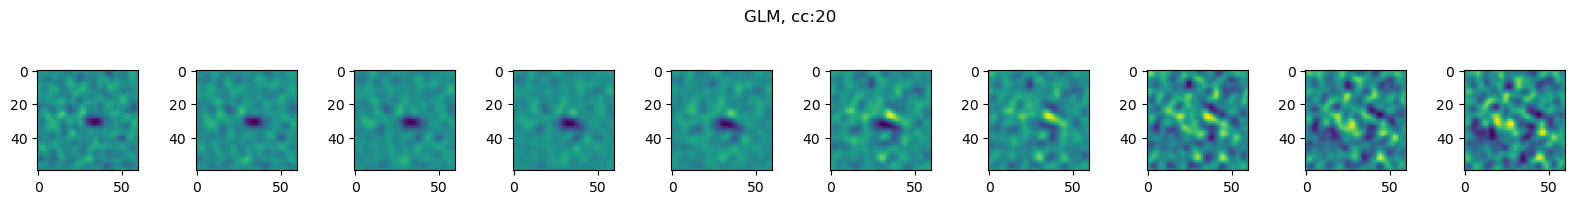

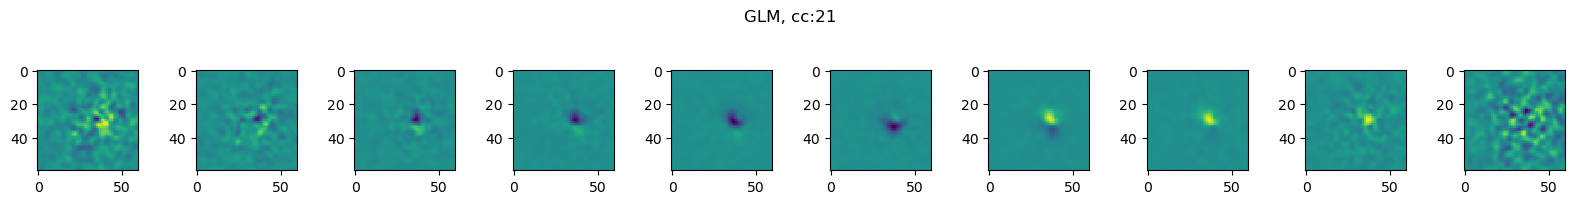

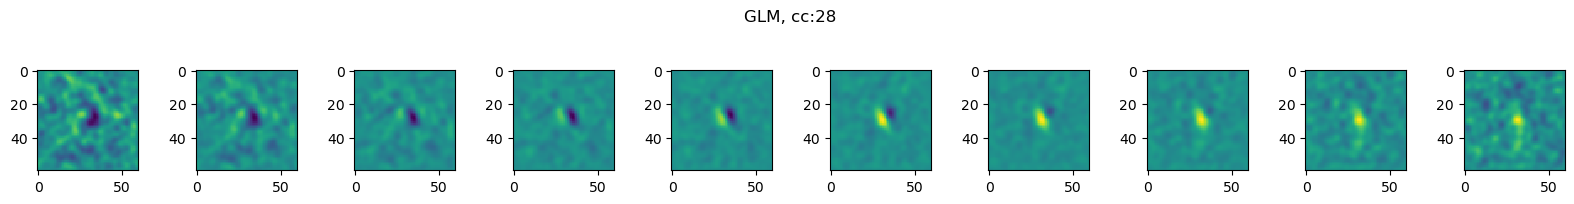

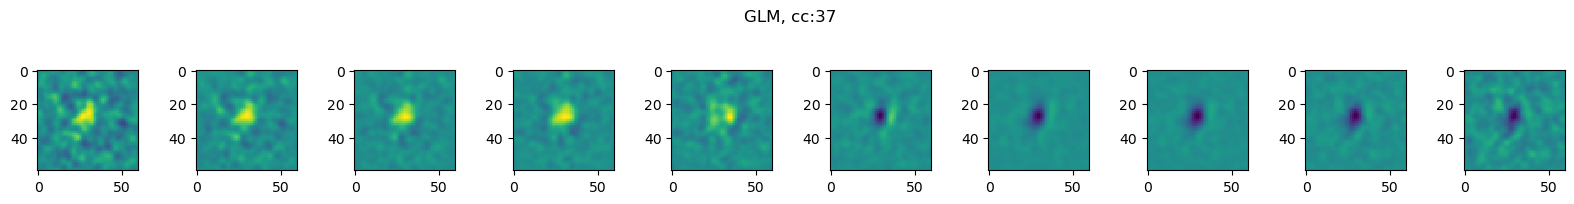

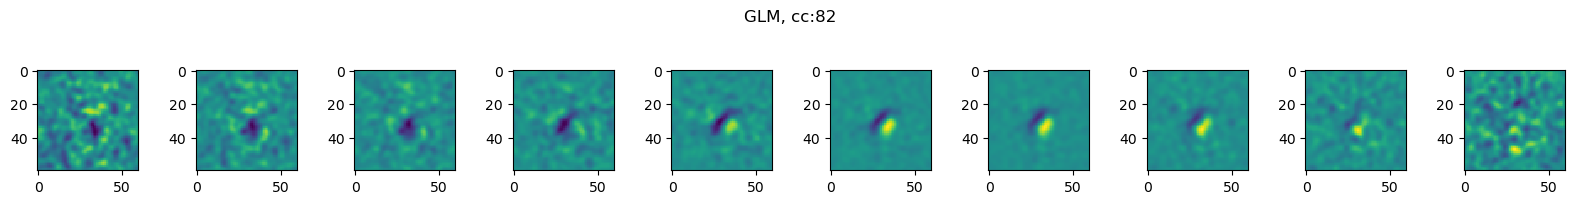

In [133]:
for i in range(len(interesting_cells)):
    ss(1,10)
    for lag in range(10):
        plt.subplot(1,10, lag+1)
        imagesc(glms[i].ndn_model.networks[0].layers[0].get_weights()[:,:, lag, 0])
        plt.suptitle('GLM, cc:' + str(valET[interesting_cells[i]]))

0.0019235611
0.053796053
0.02038598
0.0631547
0.013866425


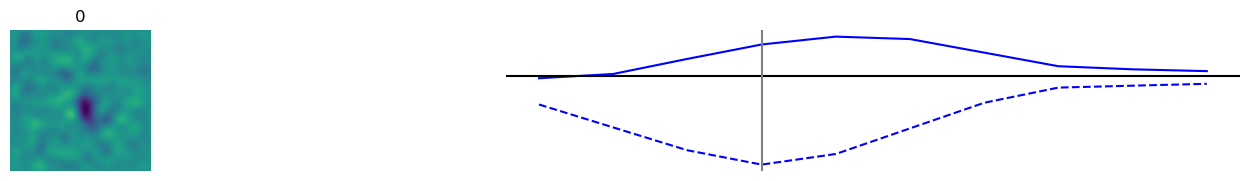

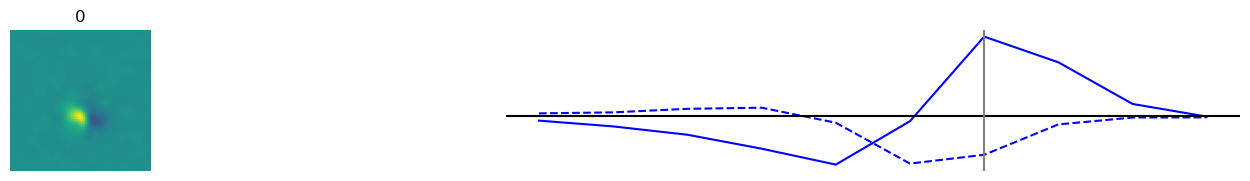

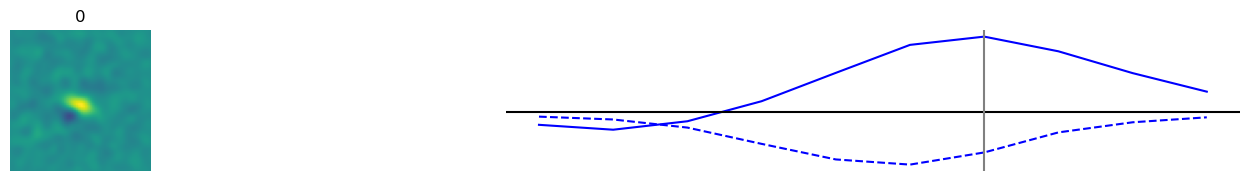

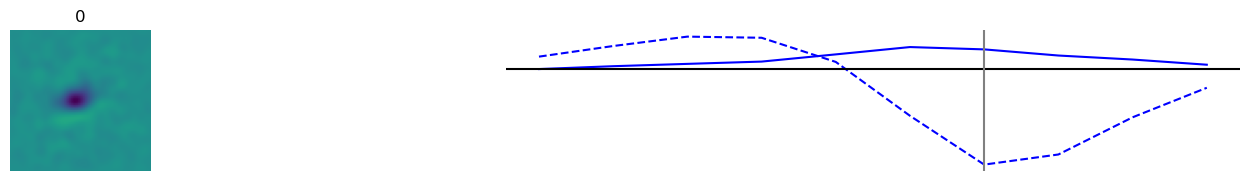

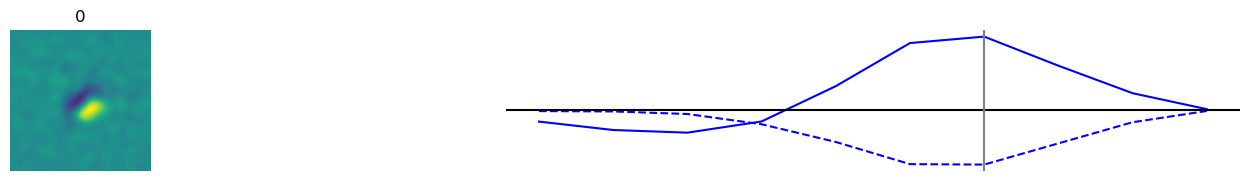

In [118]:
for glm in glms:
    print(glm.LLs)
    glm.ndn_model.plot_filters()

# GQMs

## fit GQMs

In [119]:
gqms = []
for i, cc in enumerate(interesting_cells):
    gqm_model_filename = 'models/glms_02/gqm_model_cc'+str(valET[cc])+'.pkl'
    gqm_study_filename = 'models/glms_02/gqm_study_cc'+str(valET[cc])+'.pkl'

    drift_weights = drifts[i].ndn_model.networks[0].layers[0].weight.data[:,0]

    # continue if the file already exists
    if os.path.isfile(gqm_model_filename):
        # load the model and continue
        print('loading model', cc)
        with open(gqm_model_filename, 'rb') as f:
            gqms.append(pickle.load(f))
        continue

    data.set_cells(valET[cc])

    LLsNULL = drifts[i].LLs

    # get the best reg_vals for the GLM
    best_reg_vals = glms[i].ndn_model.networks[0].layers[0].reg.vals
    stim_net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)
    gqm = NDN.NDN(ffnet_list = [stim_net, drift_net, stim_qnet, net2_comb], loss_type='poisson')
    gqm.networks[0].layers[0] = deepcopy(glms[i].ndn_model.networks[0].layers[0])
    gqm.block_sample=True
    gqm.networks[3].layers[0].set_parameters(val=False,name='weight')
    gqm.networks[1].layers[0].weight.data[:,0] = deepcopy(
        drifts[i].ndn_model.networks[0].layers[0].weight.data[:,0])
    gqm.networks[1].layers[0].set_parameters(val=False)

    gqms_temp = []

    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=trial.suggest_float('tolerance_change', 1e-10, 1e-6),
            tolerance_grad=trial.suggest_float('tolerance_grad', 1e-10, 1e-6),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)

        gqm.networks[0].layers[0].reg.vals['d2x'] = trial.suggest_float('d2x', 10, 30)
        gqm.networks[0].layers[0].reg.vals['d2t'] = trial.suggest_float('d2t', 0.5, 2)
        gqm.networks[0].layers[0].reg.vals['d2xt'] = trial.suggest_float('d2xt', 0.001, 10000)
        gqm.networks[0].layers[0].reg.vals['l1'] = trial.suggest_float('l1', 0.01, 1)
        gqm.networks[0].layers[0].reg.vals['glocalx'] = trial.suggest_float('glocalx', 0.001, 20)

        gqm.networks[2].layers[0].reg.vals['d2x'] = trial.suggest_float('d2x', 10, 30)
        gqm.networks[2].layers[0].reg.vals['d2t'] = trial.suggest_float('d2t', 0.5, 2)
        gqm.networks[2].layers[0].reg.vals['d2xt'] = trial.suggest_float('d2xt', 0.001, 10000)
        gqm.networks[2].layers[0].reg.vals['l1'] = trial.suggest_float('l1', 0.01, 1)
        gqm.networks[2].layers[0].reg.vals['glocalx'] = trial.suggest_float('glocalx', 0.001, 20)

        gqm.fit( data, force_dict_training=True, **lbfgs_pars)
        LL = gqm.eval_models(data[data.val_blks], null_adjusted=False)[0]

        null_adjusted_LL = LLsNULL - LL

        gqm_model = Model(gqm, null_adjusted_LL, trial)
        gqms_temp.append(gqm_model)

        return null_adjusted_LL

    study = optuna.create_study(direction='maximize')

    # enqueue initial parameters
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 0.001,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 0.01,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 0.1,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 1,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    study.enqueue_trial(
        {'d2t': 1,
         'd2x': 20,
         'd2xt': 10,
         'l1': 0.1,
         'glocalx': 10.0,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})

    study.optimize(objective, n_trials=15)

    best_model = gqms_temp[study.best_trial.number]

    gqms.append(best_model)

    with open(gqm_model_filename, 'wb') as f:
        pickle.dump(best_model, f)
        
    with open(gqm_study_filename, 'wb') as f:
        pickle.dump(study, f)

    print(study.best_trial.number, study.best_params)

[I 2023-07-10 15:53:18,263] A new study created in memory with name: no-name-b708af3d-fb13-46c5-a196-208f4ac1ea48


Output set to 1 cells
input dims [4, 1, 1, 1]

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 24.01397442817688 sec elapsed


[I 2023-07-10 15:53:43,539] Trial 0 finished with value: -0.013671398162841797 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.013671398162841797.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.1212751865386963 sec elapsed


[I 2023-07-10 15:53:47,902] Trial 1 finished with value: -0.01367950439453125 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.013671398162841797.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.998671054840088 sec elapsed


[I 2023-07-10 15:53:51,140] Trial 2 finished with value: -0.013676643371582031 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: -0.013671398162841797.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8121957778930664 sec elapsed


[I 2023-07-10 15:53:55,193] Trial 3 finished with value: -0.013658761978149414 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 3 with value: -0.013658761978149414.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.622775316238403 sec elapsed


[I 2023-07-10 15:54:03,061] Trial 4 finished with value: -0.01347494125366211 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: -0.01347494125366211.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 14.88731598854065 sec elapsed


[I 2023-07-10 15:54:19,189] Trial 5 finished with value: -0.0005946159362792969 and parameters: {'tolerance_change': 4.2992988564409073e-07, 'tolerance_grad': 9.326736415377609e-07, 'd2x': 11.485332931552568, 'd2t': 0.5028766820783072, 'd2xt': 5370.695420711914, 'l1': 0.5698114692136231, 'glocalx': 18.63603737120737}. Best is trial 5 with value: -0.0005946159362792969.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.261244297027588 sec elapsed


[I 2023-07-10 15:54:27,693] Trial 6 finished with value: -0.0016903877258300781 and parameters: {'tolerance_change': 1.8079180893543146e-07, 'tolerance_grad': 5.86561639013152e-07, 'd2x': 21.632608672021227, 'd2t': 0.744420605031374, 'd2xt': 2879.573249530874, 'l1': 0.5841282245949276, 'glocalx': 18.935671082423568}. Best is trial 5 with value: -0.0005946159362792969.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 16.563417434692383 sec elapsed


[I 2023-07-10 15:54:45,504] Trial 7 finished with value: -0.0039255619049072266 and parameters: {'tolerance_change': 2.585644981675144e-07, 'tolerance_grad': 8.48327684648222e-07, 'd2x': 12.403659394681954, 'd2t': 1.2273638174814363, 'd2xt': 4444.365523805581, 'l1': 0.08723207591326243, 'glocalx': 6.135536432316321}. Best is trial 5 with value: -0.0005946159362792969.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.059723138809204 sec elapsed


[I 2023-07-10 15:54:53,801] Trial 8 finished with value: -0.0031578540802001953 and parameters: {'tolerance_change': 6.039332595437569e-07, 'tolerance_grad': 9.666025072247512e-07, 'd2x': 25.76826492967239, 'd2t': 1.5559936079421726, 'd2xt': 3359.3183869147056, 'l1': 0.4958885431407006, 'glocalx': 9.194619960525044}. Best is trial 5 with value: -0.0005946159362792969.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.516904830932617 sec elapsed


[I 2023-07-10 15:55:03,562] Trial 9 finished with value: -0.00782012939453125 and parameters: {'tolerance_change': 4.871575853625753e-07, 'tolerance_grad': 2.2321654049711962e-07, 'd2x': 12.572094908127118, 'd2t': 1.8564522143994169, 'd2xt': 247.9224407983017, 'l1': 0.28255529084979886, 'glocalx': 11.612993876785545}. Best is trial 5 with value: -0.0005946159362792969.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.341850757598877 sec elapsed


[I 2023-07-10 15:55:14,164] Trial 10 finished with value: 0.0004634857177734375 and parameters: {'tolerance_change': 9.159655393461676e-07, 'tolerance_grad': 7.221317403743796e-07, 'd2x': 10.06597821965884, 'd2t': 0.5568740221846428, 'd2xt': 7822.07010301134, 'l1': 0.9257127390802324, 'glocalx': 19.339093683350672}. Best is trial 10 with value: 0.0004634857177734375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.233027696609497 sec elapsed


[I 2023-07-10 15:55:17,661] Trial 11 finished with value: 0.00046944618225097656 and parameters: {'tolerance_change': 9.865646971424065e-07, 'tolerance_grad': 7.473124192271342e-07, 'd2x': 10.06591971242258, 'd2t': 0.5421723737005008, 'd2xt': 8073.618337822645, 'l1': 0.9732541777704777, 'glocalx': 19.069933941723534}. Best is trial 11 with value: 0.00046944618225097656.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.402940273284912 sec elapsed


[I 2023-07-10 15:55:21,325] Trial 12 finished with value: 0.0004410743713378906 and parameters: {'tolerance_change': 9.699130264772654e-07, 'tolerance_grad': 7.05006281298497e-07, 'd2x': 10.13857875436311, 'd2t': 0.5090427937392162, 'd2xt': 8752.188362048495, 'l1': 0.9710223446805868, 'glocalx': 16.77881895369129}. Best is trial 11 with value: 0.00046944618225097656.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4008753299713135 sec elapsed


[I 2023-07-10 15:55:24,982] Trial 13 finished with value: 0.00040435791015625 and parameters: {'tolerance_change': 9.960144672735139e-07, 'tolerance_grad': 7.264139974443879e-07, 'd2x': 14.320336735677415, 'd2t': 0.6821984544702937, 'd2xt': 8999.320789952395, 'l1': 0.9978856979018661, 'glocalx': 16.115416430859582}. Best is trial 11 with value: 0.00046944618225097656.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 36.95143008232117 sec elapsed


[I 2023-07-10 15:56:03,214] Trial 14 finished with value: -0.013235092163085938 and parameters: {'tolerance_change': 8.416110075067659e-07, 'tolerance_grad': 4.788447542690151e-07, 'd2x': 15.153265813619711, 'd2t': 0.745608657302132, 'd2xt': 7714.382494388079, 'l1': 0.8412717493421515, 'glocalx': 0.20968365441677506}. Best is trial 11 with value: 0.00046944618225097656.
[I 2023-07-10 15:56:03,313] A new study created in memory with name: no-name-99ff0ef4-433e-44bb-89d2-011d2ea0207a


11 {'tolerance_change': 9.865646971424065e-07, 'tolerance_grad': 7.473124192271342e-07, 'd2x': 10.06591971242258, 'd2t': 0.5421723737005008, 'd2xt': 8073.618337822645, 'l1': 0.9732541777704777, 'glocalx': 19.069933941723534}
Output set to 1 cells
input dims [4, 1, 1, 1]

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 17.004066705703735 sec elapsed


[I 2023-07-10 15:56:21,591] Trial 0 finished with value: 0.053830623626708984 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.053830623626708984.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.890167236328125 sec elapsed


[I 2023-07-10 15:56:30,716] Trial 1 finished with value: 0.053835272789001465 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.053835272789001465.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.208405017852783 sec elapsed


[I 2023-07-10 15:56:34,162] Trial 2 finished with value: 0.05383646488189697 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.05383646488189697.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.487820386886597 sec elapsed


[I 2023-07-10 15:56:39,899] Trial 3 finished with value: 0.053839683532714844 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 3 with value: 0.053839683532714844.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.305092811584473 sec elapsed


[I 2023-07-10 15:56:45,473] Trial 4 finished with value: 0.05385446548461914 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: 0.05385446548461914.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.868029356002808 sec elapsed


[I 2023-07-10 15:56:55,612] Trial 5 finished with value: 0.03931844234466553 and parameters: {'tolerance_change': 8.177098477849196e-07, 'tolerance_grad': 8.875669169866996e-07, 'd2x': 17.319712086031814, 'd2t': 0.9760060804344102, 'd2xt': 4526.1547488732895, 'l1': 0.6741723455134476, 'glocalx': 5.339250998859748}. Best is trial 4 with value: 0.05385446548461914.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 27.563037395477295 sec elapsed


[I 2023-07-10 15:57:24,445] Trial 6 finished with value: 0.03122246265411377 and parameters: {'tolerance_change': 7.409127971638373e-07, 'tolerance_grad': 6.844221292393998e-07, 'd2x': 19.080591366940702, 'd2t': 1.9092966353745702, 'd2xt': 7505.176418137513, 'l1': 0.07342734424001793, 'glocalx': 0.15884348618211513}. Best is trial 4 with value: 0.05385446548461914.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.064245462417603 sec elapsed


[I 2023-07-10 15:57:33,756] Trial 7 finished with value: 0.03397345542907715 and parameters: {'tolerance_change': 9.822841443571855e-07, 'tolerance_grad': 8.909968715096862e-07, 'd2x': 29.914010696117433, 'd2t': 1.739543588526494, 'd2xt': 8064.118125525582, 'l1': 0.6311137138403068, 'glocalx': 3.9183784158222426}. Best is trial 4 with value: 0.05385446548461914.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 14.623340368270874 sec elapsed


[I 2023-07-10 15:57:49,614] Trial 8 finished with value: 0.05432248115539551 and parameters: {'tolerance_change': 2.982949142026659e-09, 'tolerance_grad': 5.011133472040356e-07, 'd2x': 24.46133466589055, 'd2t': 1.168344724726318, 'd2xt': 293.61715386468785, 'l1': 0.2606752120883899, 'glocalx': 17.407037240216276}. Best is trial 8 with value: 0.05432248115539551.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.53299593925476 sec elapsed


[I 2023-07-10 15:58:00,387] Trial 9 finished with value: 0.035550713539123535 and parameters: {'tolerance_change': 6.283202835958548e-07, 'tolerance_grad': 3.018733043240126e-07, 'd2x': 15.307366449473054, 'd2t': 1.2528839692068416, 'd2xt': 7366.452893964715, 'l1': 0.016026638138097092, 'glocalx': 18.38033383312563}. Best is trial 8 with value: 0.05432248115539551.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.828124523162842 sec elapsed


[I 2023-07-10 15:58:09,475] Trial 10 finished with value: 0.04306650161743164 and parameters: {'tolerance_change': 2.954787883527447e-07, 'tolerance_grad': 4.7290382276938676e-07, 'd2x': 11.282022592253345, 'd2t': 0.6229661850652992, 'd2xt': 3238.40325969481, 'l1': 0.9584502667854963, 'glocalx': 19.649730390247175}. Best is trial 8 with value: 0.05432248115539551.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.807233095169067 sec elapsed


[I 2023-07-10 15:58:17,539] Trial 11 finished with value: 0.045580267906188965 and parameters: {'tolerance_change': 2.5533030885511296e-07, 'tolerance_grad': 3.138559377505135e-07, 'd2x': 24.312489685330952, 'd2t': 1.3865116499936214, 'd2xt': 2340.0525489911474, 'l1': 0.30582537274538935, 'glocalx': 14.689221099386572}. Best is trial 8 with value: 0.05432248115539551.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.070440292358398 sec elapsed


[I 2023-07-10 15:58:22,866] Trial 12 finished with value: 0.04665565490722656 and parameters: {'tolerance_change': 2.1756434321964028e-07, 'tolerance_grad': 5.92146819133112e-07, 'd2x': 24.32372960299674, 'd2t': 1.454253585326465, 'd2xt': 2000.259323370031, 'l1': 0.32129768853161106, 'glocalx': 14.683744206652658}. Best is trial 8 with value: 0.05432248115539551.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.096753358840942 sec elapsed


[I 2023-07-10 15:58:29,222] Trial 13 finished with value: 0.04820740222930908 and parameters: {'tolerance_change': 3.993339044076642e-07, 'tolerance_grad': 2.6650621398205624e-07, 'd2x': 23.696875348916766, 'd2t': 0.6959387152091672, 'd2xt': 1599.715500882035, 'l1': 0.29086349866134237, 'glocalx': 14.357808318360156}. Best is trial 8 with value: 0.05432248115539551.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.344586372375488 sec elapsed


[I 2023-07-10 15:58:37,832] Trial 14 finished with value: 0.038980841636657715 and parameters: {'tolerance_change': 1.6671291871689675e-07, 'tolerance_grad': 4.3809172610127707e-07, 'd2x': 23.116032473631506, 'd2t': 0.7631441509857199, 'd2xt': 5081.488214811494, 'l1': 0.2673698157647525, 'glocalx': 13.095744700110362}. Best is trial 8 with value: 0.05432248115539551.
[I 2023-07-10 15:58:37,865] A new study created in memory with name: no-name-52f966d6-d6e0-425d-ab35-2d119b704ecb


8 {'tolerance_change': 2.982949142026659e-09, 'tolerance_grad': 5.011133472040356e-07, 'd2x': 24.46133466589055, 'd2t': 1.168344724726318, 'd2xt': 293.61715386468785, 'l1': 0.2606752120883899, 'glocalx': 17.407037240216276}
Output set to 1 cells
input dims [4, 1, 1, 1]

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 16.892998456954956 sec elapsed


[I 2023-07-10 15:58:55,991] Trial 0 finished with value: 0.010759830474853516 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.010759830474853516.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4438107013702393 sec elapsed


[I 2023-07-10 15:58:59,674] Trial 1 finished with value: 0.010785579681396484 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.010785579681396484.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.3870294094085693 sec elapsed


[I 2023-07-10 15:59:03,298] Trial 2 finished with value: 0.010788202285766602 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 2 with value: 0.010788202285766602.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.8616673946380615 sec elapsed


[I 2023-07-10 15:59:09,395] Trial 3 finished with value: 0.01133418083190918 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 3 with value: 0.01133418083190918.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.053069114685059 sec elapsed


[I 2023-07-10 15:59:14,684] Trial 4 finished with value: 0.011800527572631836 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: 0.011800527572631836.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 17.78499722480774 sec elapsed


[I 2023-07-10 15:59:33,705] Trial 5 finished with value: 0.010502099990844727 and parameters: {'tolerance_change': 7.613268810268571e-07, 'tolerance_grad': 3.082397160504395e-07, 'd2x': 15.76686436003026, 'd2t': 1.3450256957572209, 'd2xt': 8983.239708434292, 'l1': 0.43501174697019235, 'glocalx': 4.508572994288492}. Best is trial 4 with value: 0.011800527572631836.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.09584903717041 sec elapsed


[I 2023-07-10 15:59:44,069] Trial 6 finished with value: 0.014505386352539062 and parameters: {'tolerance_change': 1.8828509677853596e-07, 'tolerance_grad': 3.919737206221573e-07, 'd2x': 18.296662883295003, 'd2t': 1.3637775578577152, 'd2xt': 2913.855699792777, 'l1': 0.20793463697086342, 'glocalx': 6.306900800741874}. Best is trial 6 with value: 0.014505386352539062.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.177471876144409 sec elapsed


[I 2023-07-10 15:59:52,516] Trial 7 finished with value: 0.013402223587036133 and parameters: {'tolerance_change': 4.1660525952694426e-07, 'tolerance_grad': 4.819792782190665e-07, 'd2x': 28.815290253533906, 'd2t': 1.8177292993117249, 'd2xt': 5580.026693493942, 'l1': 0.58508536360842, 'glocalx': 9.462179284354521}. Best is trial 6 with value: 0.014505386352539062.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.516221046447754 sec elapsed


[I 2023-07-10 15:59:59,266] Trial 8 finished with value: 0.017842531204223633 and parameters: {'tolerance_change': 9.627778816741258e-07, 'tolerance_grad': 1.7561760512052548e-07, 'd2x': 22.14214523850822, 'd2t': 0.9865857439906258, 'd2xt': 546.6021702414458, 'l1': 0.43305676940969173, 'glocalx': 12.259433408987396}. Best is trial 8 with value: 0.017842531204223633.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.179839611053467 sec elapsed


[I 2023-07-10 16:00:08,728] Trial 9 finished with value: 0.011159896850585938 and parameters: {'tolerance_change': 2.250042521156141e-07, 'tolerance_grad': 9.159697137479291e-07, 'd2x': 13.026558319559658, 'd2t': 1.929913097446664, 'd2xt': 9037.147580258716, 'l1': 0.0463379802961305, 'glocalx': 7.825427669665358}. Best is trial 8 with value: 0.017842531204223633.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.8363196849823 sec elapsed


[I 2023-07-10 16:00:16,854] Trial 10 finished with value: 0.016585111618041992 and parameters: {'tolerance_change': 9.983479034781012e-07, 'tolerance_grad': 2.49913828963357e-07, 'd2x': 24.89208083988096, 'd2t': 0.5505836465934624, 'd2xt': 2509.154685421275, 'l1': 0.8593759772666656, 'glocalx': 16.01995351140822}. Best is trial 8 with value: 0.017842531204223633.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8596351146698 sec elapsed


[I 2023-07-10 16:00:21,006] Trial 11 finished with value: 0.016319751739501953 and parameters: {'tolerance_change': 9.716710518816275e-07, 'tolerance_grad': 2.99014324555239e-07, 'd2x': 24.938837510127225, 'd2t': 0.5267416244708961, 'd2xt': 2790.768480442274, 'l1': 0.9632824312511046, 'glocalx': 16.224219549106376}. Best is trial 8 with value: 0.017842531204223633.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.0061333179473877 sec elapsed


[I 2023-07-10 16:00:25,266] Trial 12 finished with value: 0.0167694091796875 and parameters: {'tolerance_change': 9.930417678790483e-07, 'tolerance_grad': 2.2834109162025825e-07, 'd2x': 24.727517108020784, 'd2t': 0.5002969921445525, 'd2xt': 2325.7716697245714, 'l1': 0.8373207299109022, 'glocalx': 14.724944298975263}. Best is trial 8 with value: 0.017842531204223633.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.212501049041748 sec elapsed


[I 2023-07-10 16:00:29,733] Trial 13 finished with value: 0.016967058181762695 and parameters: {'tolerance_change': 8.054602706433677e-07, 'tolerance_grad': 1.9066926967800042e-07, 'd2x': 24.80963179360668, 'd2t': 0.6581894819371816, 'd2xt': 2121.6720468733597, 'l1': 0.7393082766102502, 'glocalx': 14.14456863734185}. Best is trial 8 with value: 0.017842531204223633.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.483735799789429 sec elapsed


[I 2023-07-10 16:00:35,472] Trial 14 finished with value: 0.01763916015625 and parameters: {'tolerance_change': 7.788312656859075e-07, 'tolerance_grad': 6.006614148712041e-07, 'd2x': 23.210504648989023, 'd2t': 0.7458078549097649, 'd2xt': 1473.0818006740865, 'l1': 0.5924555067652327, 'glocalx': 13.251328159854083}. Best is trial 8 with value: 0.017842531204223633.
[I 2023-07-10 16:00:35,493] A new study created in memory with name: no-name-512257cc-9dae-4b7c-92f6-2ae6338ccdb0


8 {'tolerance_change': 9.627778816741258e-07, 'tolerance_grad': 1.7561760512052548e-07, 'd2x': 22.14214523850822, 'd2t': 0.9865857439906258, 'd2xt': 546.6021702414458, 'l1': 0.43305676940969173, 'glocalx': 12.259433408987396}
Output set to 1 cells
input dims [4, 1, 1, 1]

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 21.528088569641113 sec elapsed


[I 2023-07-10 16:00:58,277] Trial 0 finished with value: 0.06478762626647949 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.06478762626647949.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0875320434570312 sec elapsed


[I 2023-07-10 16:01:01,616] Trial 1 finished with value: 0.06479048728942871 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.06479048728942871.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.8071279525756836 sec elapsed


[I 2023-07-10 16:01:04,693] Trial 2 finished with value: 0.06479048728942871 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.06479048728942871.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6321475505828857 sec elapsed


[I 2023-07-10 16:01:08,597] Trial 3 finished with value: 0.06481218338012695 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 3 with value: 0.06481218338012695.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.253431558609009 sec elapsed


[I 2023-07-10 16:01:13,125] Trial 4 finished with value: 0.0649874210357666 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 25.891308307647705 sec elapsed


[I 2023-07-10 16:01:40,254] Trial 5 finished with value: 0.04085183143615723 and parameters: {'tolerance_change': 3.172137558865821e-07, 'tolerance_grad': 6.977445617225957e-07, 'd2x': 20.035845597777893, 'd2t': 0.7898382288499713, 'd2xt': 9735.999076647999, 'l1': 0.2445639206368915, 'glocalx': 12.979125753192788}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 13.43437647819519 sec elapsed


[I 2023-07-10 16:01:54,958] Trial 6 finished with value: 0.055480241775512695 and parameters: {'tolerance_change': 4.763165890111694e-07, 'tolerance_grad': 1.2797780136739027e-07, 'd2x': 25.999322637497208, 'd2t': 1.654352920863286, 'd2xt': 1566.6737205892387, 'l1': 0.09912931286645427, 'glocalx': 6.840319200856166}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 15.505756616592407 sec elapsed


[I 2023-07-10 16:02:11,738] Trial 7 finished with value: 0.02005743980407715 and parameters: {'tolerance_change': 4.668875742360347e-07, 'tolerance_grad': 3.8437127793216274e-07, 'd2x': 29.873056905426058, 'd2t': 1.319525402301661, 'd2xt': 1005.3916051611769, 'l1': 0.2817844874192922, 'glocalx': 0.7875170817745053}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 14.027896165847778 sec elapsed


[I 2023-07-10 16:02:27,010] Trial 8 finished with value: 0.04100942611694336 and parameters: {'tolerance_change': 7.509732248011878e-07, 'tolerance_grad': 5.147279069160463e-07, 'd2x': 20.05354389405022, 'd2t': 1.9922259917223888, 'd2xt': 8668.356050749779, 'l1': 0.8431132913089606, 'glocalx': 5.763412823403516}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.59276008605957 sec elapsed


[I 2023-07-10 16:02:38,835] Trial 9 finished with value: 0.049672603607177734 and parameters: {'tolerance_change': 6.110965736272605e-07, 'tolerance_grad': 9.57257066905696e-07, 'd2x': 14.921205700838843, 'd2t': 1.5467752951922673, 'd2xt': 3796.069807424409, 'l1': 0.03425434367666181, 'glocalx': 12.316596869864787}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.321922540664673 sec elapsed


[I 2023-07-10 16:02:44,445] Trial 10 finished with value: 0.051126956939697266 and parameters: {'tolerance_change': 9.539108204821142e-07, 'tolerance_grad': 2.928519051644787e-07, 'd2x': 10.837080549578065, 'd2t': 0.6061383016491254, 'd2xt': 3496.892458412644, 'l1': 0.49361117149503586, 'glocalx': 18.647034066742748}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.180969715118408 sec elapsed


[I 2023-07-10 16:02:51,914] Trial 11 finished with value: 0.05485391616821289 and parameters: {'tolerance_change': 2.243366239680343e-07, 'tolerance_grad': 2.0387884867608508e-07, 'd2x': 24.057070741450865, 'd2t': 0.5765390383843975, 'd2xt': 2323.532934277597, 'l1': 0.3859505513039033, 'glocalx': 15.678125019611457}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.405951023101807 sec elapsed


[I 2023-07-10 16:03:03,593] Trial 12 finished with value: 0.045191287994384766 and parameters: {'tolerance_change': 1.757434456542739e-07, 'tolerance_grad': 2.0400940730686757e-07, 'd2x': 16.10407283725492, 'd2t': 1.2174243846126005, 'd2xt': 5610.243914907859, 'l1': 0.6636840761963192, 'glocalx': 6.830973637374189}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.67113471031189 sec elapsed


[I 2023-07-10 16:03:12,550] Trial 13 finished with value: 0.055426836013793945 and parameters: {'tolerance_change': 1.867753580779719e-07, 'tolerance_grad': 1.4205379804328327e-07, 'd2x': 23.33331754829144, 'd2t': 0.8106648506599641, 'd2xt': 2207.5374850213007, 'l1': 0.2632252379686401, 'glocalx': 14.501804160386303}. Best is trial 4 with value: 0.0649874210357666.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.123755693435669 sec elapsed


[I 2023-07-10 16:03:18,930] Trial 14 finished with value: 0.06018209457397461 and parameters: {'tolerance_change': 3.3628892084227305e-07, 'tolerance_grad': 3.760943400730149e-07, 'd2x': 16.684402276705274, 'd2t': 1.2039864708188233, 'd2xt': 1339.755903357606, 'l1': 0.4289407008554079, 'glocalx': 17.455308301285278}. Best is trial 4 with value: 0.0649874210357666.
[I 2023-07-10 16:03:18,953] A new study created in memory with name: no-name-40e70069-a3e0-49cd-b88b-8fc6ba1bfe9f


4 {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}
Output set to 1 cells
input dims [4, 1, 1, 1]

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 12.456933498382568 sec elapsed


[I 2023-07-10 16:03:32,671] Trial 0 finished with value: 0.013004541397094727 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.001, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 0 with value: 0.013004541397094727.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.0940136909484863 sec elapsed


[I 2023-07-10 16:03:37,032] Trial 1 finished with value: 0.013016700744628906 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.01, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.013016700744628906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.989241600036621 sec elapsed


[I 2023-07-10 16:03:40,254] Trial 2 finished with value: 0.013015985488891602 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 0.1, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 1 with value: 0.013016700744628906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9851255416870117 sec elapsed


[I 2023-07-10 16:03:43,474] Trial 3 finished with value: 0.013023138046264648 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 1.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 3 with value: 0.013023138046264648.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.884505033493042 sec elapsed


[I 2023-07-10 16:03:49,591] Trial 4 finished with value: 0.013120174407958984 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'd2xt': 10.0, 'l1': 0.1, 'glocalx': 10.0}. Best is trial 4 with value: 0.013120174407958984.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.121512174606323 sec elapsed


[I 2023-07-10 16:03:59,962] Trial 5 finished with value: -0.0026123523712158203 and parameters: {'tolerance_change': 3.504295014530817e-08, 'tolerance_grad': 8.527284737299508e-07, 'd2x': 25.280391507886485, 'd2t': 1.2345213388278309, 'd2xt': 227.58873420828908, 'l1': 0.520287042173937, 'glocalx': 3.36587043230855}. Best is trial 4 with value: 0.013120174407958984.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 16.996277809143066 sec elapsed


[I 2023-07-10 16:04:18,193] Trial 6 finished with value: 0.013527154922485352 and parameters: {'tolerance_change': 6.777294964851942e-07, 'tolerance_grad': 8.296630164639892e-07, 'd2x': 15.944925545073652, 'd2t': 1.691342906331346, 'd2xt': 9126.423851258249, 'l1': 0.9127392968840253, 'glocalx': 10.584191169304846}. Best is trial 6 with value: 0.013527154922485352.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.190115451812744 sec elapsed


[I 2023-07-10 16:04:29,617] Trial 7 finished with value: 0.014488935470581055 and parameters: {'tolerance_change': 3.55108750523547e-07, 'tolerance_grad': 3.486387065343479e-07, 'd2x': 25.03887358983974, 'd2t': 0.9020414448305711, 'd2xt': 3484.367229935411, 'l1': 0.6772021065272548, 'glocalx': 15.695437020425352}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.584195613861084 sec elapsed


[I 2023-07-10 16:04:37,436] Trial 8 finished with value: 0.01356196403503418 and parameters: {'tolerance_change': 5.220235059111735e-07, 'tolerance_grad': 5.405058084588143e-07, 'd2x': 29.327374259758418, 'd2t': 1.6686815528140113, 'd2xt': 422.1522785716967, 'l1': 0.049710237489683305, 'glocalx': 9.341226408352876}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 24.279689073562622 sec elapsed


[I 2023-07-10 16:05:02,951] Trial 9 finished with value: 0.013186931610107422 and parameters: {'tolerance_change': 5.660336192505983e-08, 'tolerance_grad': 9.455367637072088e-07, 'd2x': 10.20093356458876, 'd2t': 0.6545454713484695, 'd2xt': 5441.143616105791, 'l1': 0.0905403736748694, 'glocalx': 19.441627675094217}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.61195969581604 sec elapsed


[I 2023-07-10 16:05:09,820] Trial 10 finished with value: 0.013922452926635742 and parameters: {'tolerance_change': 9.861852525557216e-07, 'tolerance_grad': 3.0857563314463296e-07, 'd2x': 25.547712349680296, 'd2t': 0.6360091241716808, 'd2xt': 3124.7607309761393, 'l1': 0.741263142590145, 'glocalx': 19.132240253514595}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0083208084106445 sec elapsed


[I 2023-07-10 16:05:13,129] Trial 11 finished with value: 0.013895273208618164 and parameters: {'tolerance_change': 9.724955379972987e-07, 'tolerance_grad': 2.986144929820509e-07, 'd2x': 25.913531703329507, 'd2t': 0.5419147910791551, 'd2xt': 3276.671426830848, 'l1': 0.7450719590198192, 'glocalx': 18.916008982208815}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.344222545623779 sec elapsed


[I 2023-07-10 16:05:19,749] Trial 12 finished with value: 0.013392210006713867 and parameters: {'tolerance_change': 2.964996802256005e-07, 'tolerance_grad': 3.5083919223186576e-07, 'd2x': 25.129160650823135, 'd2t': 0.6977372939603419, 'd2xt': 4596.8948365659835, 'l1': 0.6794879037254775, 'glocalx': 16.696323588505887}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.326963186264038 sec elapsed


[I 2023-07-10 16:05:26,328] Trial 13 finished with value: 0.013887166976928711 and parameters: {'tolerance_change': 9.987818687338174e-07, 'tolerance_grad': 3.052228049498507e-07, 'd2x': 27.247819870270156, 'd2t': 0.7612172320752757, 'd2xt': 2590.318833647751, 'l1': 0.9492891916845472, 'glocalx': 16.523299747914376}. Best is trial 7 with value: 0.014488935470581055.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.2564682960510254 sec elapsed


[I 2023-07-10 16:05:30,865] Trial 14 finished with value: 0.013547658920288086 and parameters: {'tolerance_change': 7.963194552975639e-07, 'tolerance_grad': 5.062562863170772e-07, 'd2x': 23.297237827472404, 'd2t': 0.52163661271199, 'd2xt': 2289.0332227514273, 'l1': 0.738011847164475, 'glocalx': 15.590168150331516}. Best is trial 7 with value: 0.014488935470581055.


7 {'tolerance_change': 3.55108750523547e-07, 'tolerance_grad': 3.486387065343479e-07, 'd2x': 25.03887358983974, 'd2t': 0.9020414448305711, 'd2xt': 3484.367229935411, 'l1': 0.6772021065272548, 'glocalx': 15.695437020425352}


In [130]:
gqms[0].ndn_model.networks[2].layers[0].get_weights().shape

(60, 60, 10, 2)

## plot GQMs

-------------


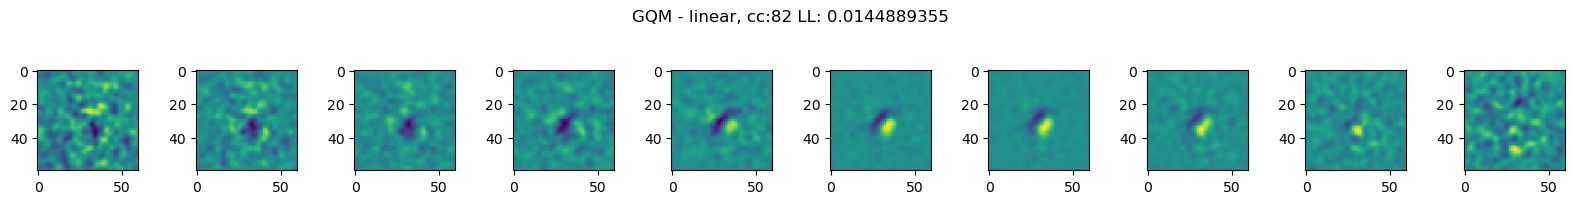

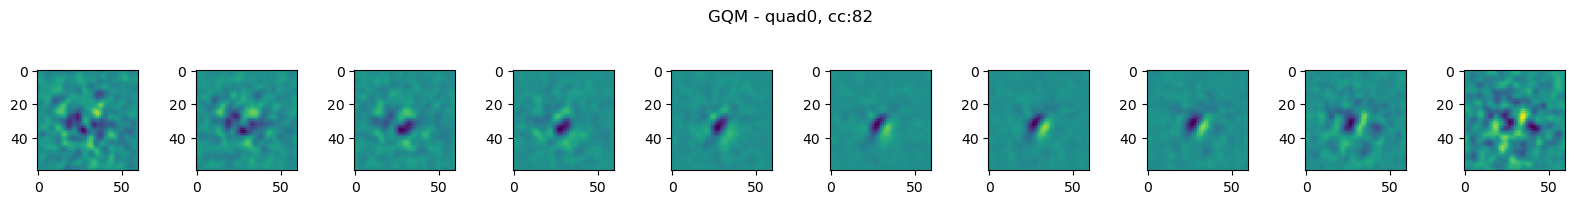

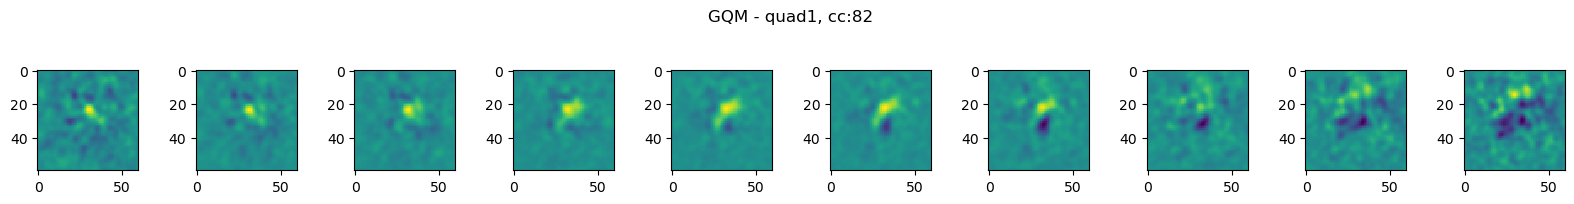

-------------


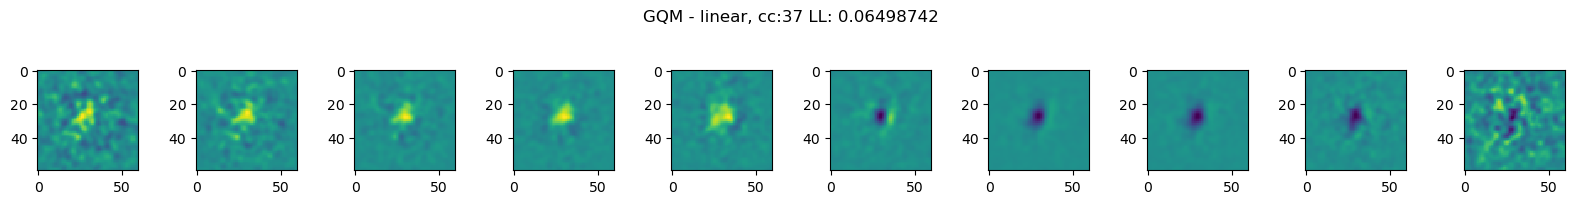

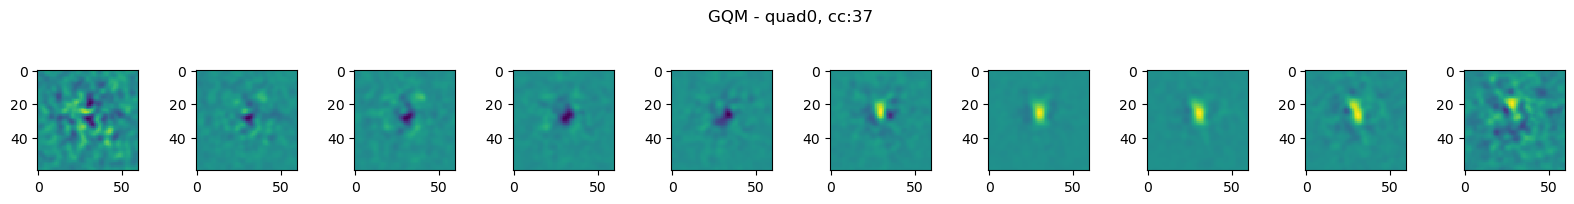

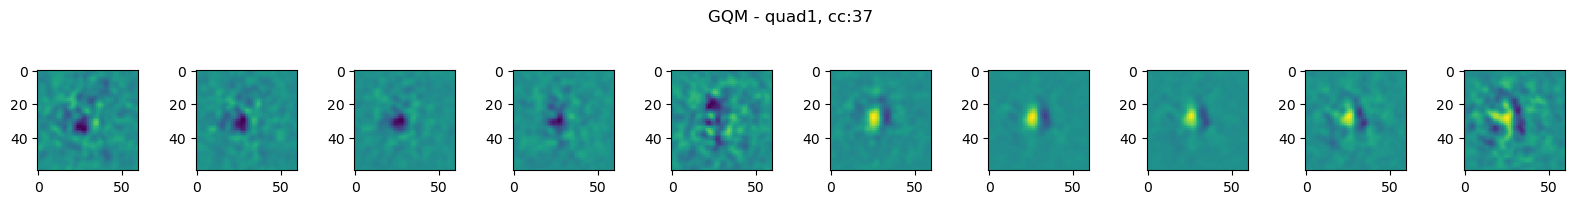

-------------


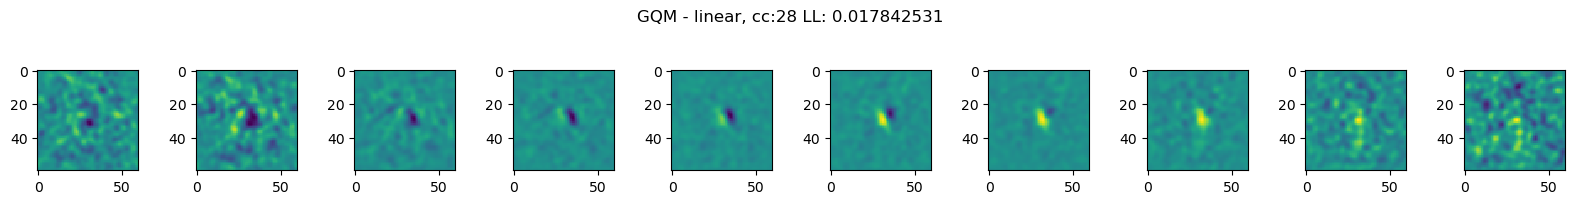

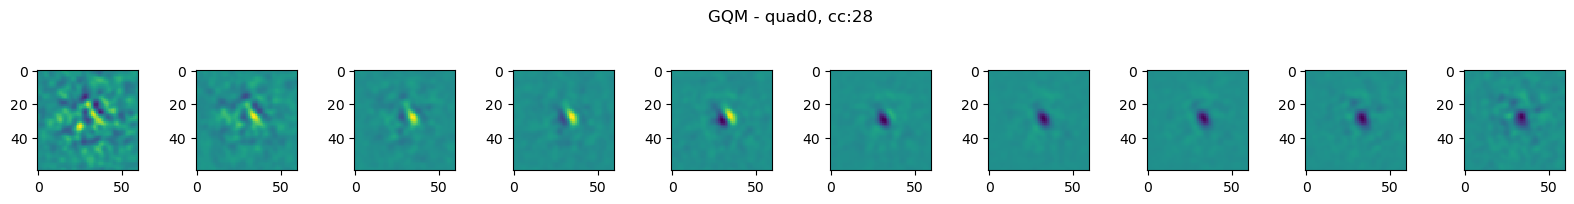

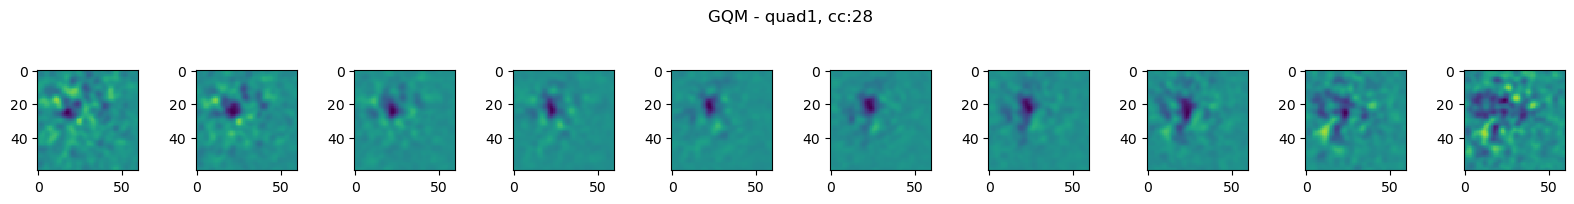

-------------


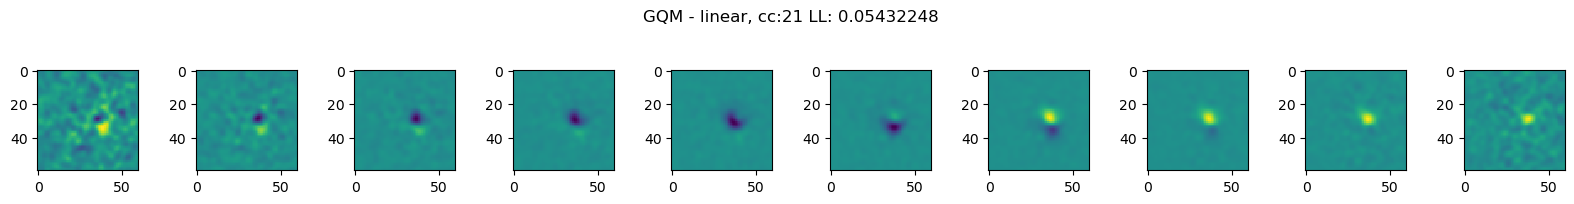

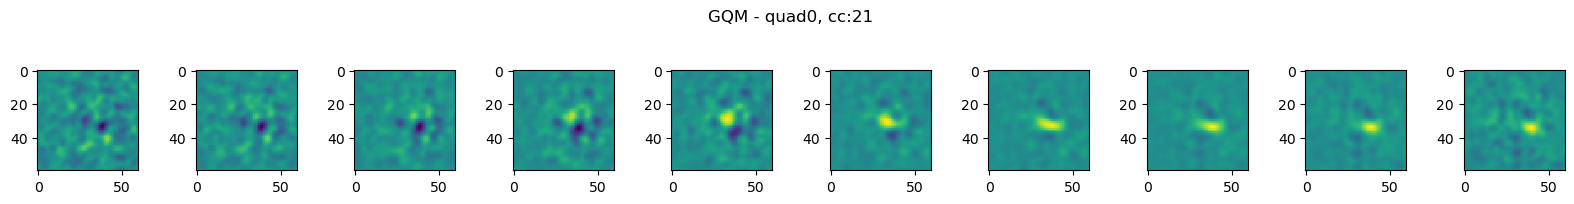

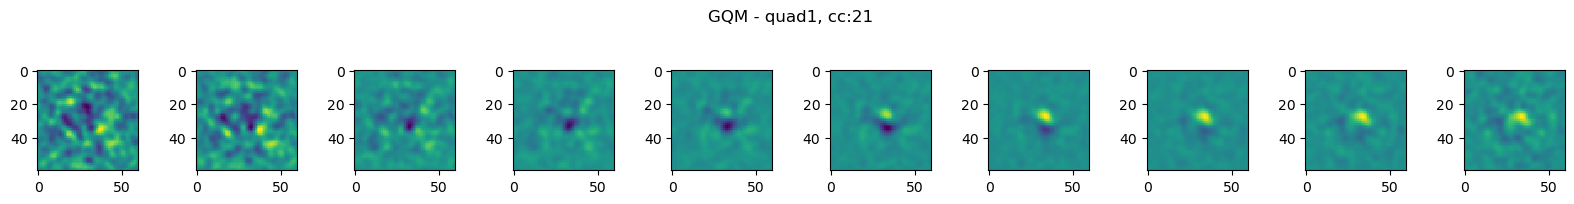

In [138]:
for i in range(len(interesting_cells)-1, 0, -1):
    print('-------------')
    ss(1,10)
    for lag in range(10):
        plt.subplot(1,10, lag+1)
        imagesc(gqms[i].ndn_model.networks[0].layers[0].get_weights()[:,:, lag, 0])
        plt.suptitle('GQM - linear, cc:' + str(valET[interesting_cells[i]]) + ' LL: ' + str(gqms[i].LLs))
    ss(1,10)
    for lag in range(10):
        plt.subplot(1,10, lag+1)
        imagesc(gqms[i].ndn_model.networks[2].layers[0].get_weights()[:,:, lag, 0])
        plt.suptitle('GQM - quad0, cc:' + str(valET[interesting_cells[i]]))
    ss(1,10)
    for lag in range(10):
        plt.subplot(1,10, lag+1)
        imagesc(gqms[i].ndn_model.networks[2].layers[0].get_weights()[:,:, lag, 1])
        plt.suptitle('GQM - quad1, cc:' + str(valET[interesting_cells[i]]))
    plt.show()

## plot cross-sections
   of direction selective cells

In [142]:
# start with cell 21 (looks like a direction selective cell)
linear = gqms[-1].ndn_model.networks[0].layers[0].get_weights()[:,:, :, 0]
quad0 = gqms[-1].ndn_model.networks[2].layers[0].get_weights()[:,:, :, 0]
quad1 = gqms[-1].ndn_model.networks[2].layers[0].get_weights()[:,:, :, 1]
linear.shape, quad0.shape, quad1.shape

((60, 60, 10), (60, 60, 10), (60, 60, 10))

In [ ]:
# take a vertical slice of each of the linear and quadratic receptive fields to plot in a single image
